# 🛍️ Decoding the Customer: A Data-Driven Journey Through E-Commerce Behaviour

---

## The Story

Every transaction tells a story. Behind each invoice number is a customer with habits, preferences, and patterns — patterns that, if understood deeply enough, can transform how a business grows.

This notebook explores a full year of real e-commerce transaction data (December 2010 – December 2011), covering roughly **4,000 customers** and half a million purchase records. The central question driving this work:

> **Can we predict what kind of customer someone will be — how often they'll buy, how much they'll spend, and what they'll purchase — based solely on their very first transaction?**

To answer this, the analysis unfolds in five acts:

1. **Data Preparation** — cleaning the raw data and making it trustworthy
2. **Exploratory Analysis** — understanding what the data contains and what it hides
3. **Product Taxonomy** — grouping products into meaningful categories using unsupervised learning
4. **Customer Archetypes** — discovering who our customers really are through clustering
5. **Predictive Classification** — building and testing a model that assigns customers to archetypes from their first purchase

---

**Table of Contents**

- **1. Data Preparation**
- **2. Exploring the Variables**
  - 2.1 Geographic Reach
  - 2.2 Customers and Products
    - 2.2.1 The Cancellation Problem
    - 2.2.2 Special Stock Codes
    - 2.2.3 Basket Price Engineering
- **3. Product Categories**
  - 3.1 Mining Product Descriptions
  - 3.2 Clustering Products into Categories
    - 3.2.1 Feature Encoding
    - 3.2.2 Finding the Right Number of Clusters
    - 3.2.3 Interpreting the Product Clusters
- **4. Customer Archetypes**
  - 4.1 Structuring the Data for Segmentation
    - 4.1.1 Aggregating by Product Category
    - 4.1.2 Splitting the Timeline
    - 4.1.3 Summarising Behaviour per Customer
  - 4.2 Building Customer Segments
    - 4.2.1 Standardising and Encoding
    - 4.2.2 K-Means Clustering on Customers
- **5. Building the Classifier**
  - 5.1 Support Vector Machine
  - 5.2 Logistic Regression
  - 5.3 k-Nearest Neighbours
  - 5.4 Decision Tree
  - 5.5 Random Forest
  - 5.6 AdaBoost
  - 5.7 Gradient Boosting
  - 5.8 Ensemble Voting
- **6. Stress-Testing on Unseen Data**
- **7. Conclusions & Reflections**


---
## Act I — Preparing the Stage: Data Ingestion & Cleaning

Before any insight can emerge, the data must be understood on its own terms. We begin by loading the full library of dependencies — visualisation tools, NLP utilities, clustering algorithms, and classifiers — that will power the analysis ahead.


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)
%matplotlib inline

### Environment & Library Versions

This notebook is written for modern Python (3.9+) and current library versions. Key version notes:

| Library        | Minimum Recommended |
|----------------|--------------------|
| pandas         | ≥ 2.0              |
| pandas         | ≥ 2.1              |
| seaborn        | ≥ 0.12             |
| plotly         | ≥ 5.0              |
| scikit-learn   | ≥ 1.0              |
| numpy          | ≥ 1.24             |




### Loading and Inspecting the Raw Data

The dataset arrives as a CSV file. We read it in, parse the invoice dates, and immediately perform a structural audit — checking column types, null counts, and the first few rows to get our bearings.


In [2]:
# Read the source data file
df_initial = pd.read_csv('data.csv', encoding="ISO-8859-1",
                         dtype={'CustomerID': str, 'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)

# Parse invoice dates as proper datetime objects
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

# Structural audit: column types, null counts, and null percentages
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_info = pd.concat([tab_info,
                      pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}),
                      pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index={0: 'null values (%)'})])
display(tab_info)

# Preview the first five records
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type            str       str         str    int64  datetime64[us]   
null values (nb)         0         0        1454        0               0   
null values (%)        0.0       0.0    0.268311      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64        str     str  
null values (nb)         0     135080       0  
null values (%)        0.0  24.926694     0.0

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55      17850  United Kingdom  
1 2010-12-01 08:26:00       3.39      17850  United Kingdom  
2 2010-12-01 08:26:00       2.75      17850  United Kingdom  
3 2010-12-01 08:26:00       3.39      17850  United Kingdom  
4 2010-12-01 08:26:00       3.39      17850  United Kingdom

### Handling Missing CustomerIDs

The audit reveals an important data quality issue: roughly **25% of all entries have no CustomerID**. These are unidentifiable transactions — we cannot link them to any individual customer, making them useless for building a customer-centric model. Rather than attempting imputation (which would fabricate identities), we remove them cleanly.


In [3]:
df_initial.dropna(axis=0, subset=['CustomerID'], inplace=True)
print('Dataframe dimensions after removing anonymous entries:', df_initial.shape)

# Verify the dataframe is now fully populated
tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_info = pd.concat([tab_info,
                      pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}),
                      pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.rename(index={0: 'null values (%)'})])
display(tab_info)

Dataframe dimensions after removing anonymous entries: (406829, 8)


InvoiceNo StockCode Description Quantity     InvoiceDate  \
column type            str       str         str    int64  datetime64[us]   
null values (nb)         0         0           0        0               0   
null values (%)        0.0       0.0         0.0      0.0             0.0   

                 UnitPrice CustomerID Country  
column type        float64        str     str  
null values (nb)         0          0       0  
null values (%)        0.0        0.0     0.0

With anonymous rows removed, the dataframe is 100% populated across all columns. One final housekeeping step: removing exact duplicate rows.


In [4]:
# Check for and remove exact duplicates
print('Duplicate entries found: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace=True)

Duplicate entries found: 5225


---
## Act II — Mapping the Territory: Exploratory Analysis

With a clean dataset in hand, we now explore its structure. The dataframe captures eight variables that together paint a picture of every transaction:

| Variable | Description |
|---|---|
| **InvoiceNo** | Unique 6-digit transaction identifier. Codes beginning with 'C' indicate a cancellation. |
| **StockCode** | Unique 5-digit product identifier. |
| **Description** | Text name of the product purchased. |
| **Quantity** | Number of units in this line item. |
| **InvoiceDate** | Date and time of the transaction. |
| **UnitPrice** | Per-unit price in GBP. |
| **CustomerID** | Unique 5-digit customer identifier. |
| **Country** | Country where the customer resides. |

---
### 2.1 Geographic Reach


First, we examine the geographic distribution of orders to understand the platform's reach:


In [5]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop=False)
countries = temp['Country'].value_counts()
print('Number of countries represented: {}'.format(len(countries)))

Number of countries represented: 37


In [6]:
# Choropleth map of orders by country using modern Plotly Express
fig = px.choropleth(
    locations=countries.index,
    locationmode='country names',
    color=countries.values,
    color_continuous_scale=[
        [0,    'rgb(224,255,255)'],
        [0.01, 'rgb(166,206,227)'],
        [0.02, 'rgb(31,120,180)'],
        [0.03, 'rgb(178,223,138)'],
        [0.05, 'rgb(51,160,44)'],
        [0.10, 'rgb(251,154,153)'],
        [0.20, 'rgb(255,255,0)'],
        [1,    'rgb(227,26,28)']
    ],
    labels={'color': 'Order count'},
    title='Order Volume by Country'
)
fig.show()

The map confirms a clear pattern: the overwhelming majority of orders originate in the **United Kingdom**, with a modest international footprint across Europe and beyond. This geographic concentration is worth keeping in mind when drawing conclusions about customer behaviour.

---
### 2.2 Customers and Products

Let us now take stock of the scale of activity in the dataset:


In [7]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),
               }], columns=['products', 'transactions', 'customers'], index=['quantity'])

products  transactions  customers
quantity      3684         22190       4372

We are working with **4,372 customers**, **3,684 distinct products**, and approximately **22,000 transactions**. Next, we look at how many products appear in each transaction — a proxy for basket richness:


In [8]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns={'InvoiceDate': 'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

CustomerID InvoiceNo  Number of products
0      12346    541431                   1
1      12346   C541433                   1
2      12347    537626                  31
3      12347    542237                  29
4      12347    549222                  24
5      12347    556201                  18
6      12347    562032                  22
7      12347    573511                  47
8      12347    581180                  11
9      12348    539318                  17

Three patterns immediately stand out from this view:
- Invoices starting with **'C'** denote **cancellations** — a non-trivial data quality challenge we must resolve
- Some customers made **a single visit and bought a single product** (e.g. customer 12346)
- Other customers are **frequent high-volume buyers** who return repeatedly with large baskets

---
#### 2.2.1 The Cancellation Problem

Cancellations could distort every downstream calculation if left unhandled. Let us first understand their scale:


In [9]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: int('C' in x))
display(nb_products_per_basket[:5])

n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Cancelled orders: {}/{} ({:.2f}%)'.format(n1, n2, n1 / n2 * 100))

CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0

Cancelled orders: 3654/22190 (16.47%)


At **~16% cancellation rate**, this is a significant proportion. The natural assumption would be that each cancellation has a corresponding original order. We test this hypothesis systematically:


In [10]:
display(df_initial.sort_values('CustomerID')[:5])

InvoiceNo StockCode                        Description  Quantity  \
61619    541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
61624   C541433     23166     MEDIUM CERAMIC TOP STORAGE JAR    -74215   
14938    537626     85116    BLACK CANDELABRA T-LIGHT HOLDER        12   
14939    537626     22375  AIRLINE BAG VINTAGE JET SET BROWN         4   
14940    537626     71477  COLOUR GLASS. STAR T-LIGHT HOLDER        12   

              InvoiceDate  UnitPrice CustomerID         Country  
61619 2011-01-18 10:01:00       1.04      12346  United Kingdom  
61624 2011-01-18 10:17:00       1.04      12346  United Kingdom  
14938 2010-12-07 14:57:00       2.10      12347         Iceland  
14939 2010-12-07 14:57:00       4.25      12347         Iceland  
14940 2010-12-07 14:57:00       3.25      12347         Iceland

In [11]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID', 'Quantity',
                                                    'StockCode', 'Description', 'UnitPrice']]
for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                  (df_initial['Quantity'] == -col['Quantity']) &
                  (df_initial['Description'] == col['Description'])].shape[0] == 0:
        print(df_check.loc[index])
        print(15 * '-' + '>' + ' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


The hypothesis breaks down immediately — a 'Discount' entry has no matching original order. We exclude discounts and retry:


In [12]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
    ['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]

for index, col in df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                  (df_initial['Quantity'] == -col['Quantity']) &
                  (df_initial['Description'] == col['Description'])].shape[0] == 0:
        print(index, df_check.loc[index])
        print(15 * '-' + '>' + ' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Still failing. Cancellations do not universally correspond to prior purchases — some may predate the dataset's start window (December 2010). Given this complexity, we take a principled approach: for each cancellation, we search for its matching original order. When a match exists, we record the cancelled quantity against the original entry. When no match can be found, we classify the entry as doubtful and set it aside for removal.


In [13]:
df_cleaned = df_initial.copy(deep=True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount':
        continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode'] == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity'] > 0)].copy()
    # Case 1: cancellation without any prior matching order
    if df_test.shape[0] == 0:
        doubtfull_entry.append(index)
    # Case 2: exactly one matching prior order found
    elif df_test.shape[0] == 1:
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    # Case 3: multiple prior orders exist — attribute cancellation to the most recent
    elif df_test.shape[0] > 1:
        df_test.sort_index(axis=0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:
                continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [14]:
print("Cancellations matched and flagged for removal: {}".format(len(entry_to_remove)))
print("Unmatched cancellations (no prior order found): {}".format(len(doubtfull_entry)))

Cancellations matched and flagged for removal: 7521
Unmatched cancellations (no prior order found): 1226


Both categories together account for less than 1.6% of the dataset. We remove them:


In [15]:
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("Remaining unresolved negative-quantity entries: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

Remaining unresolved negative-quantity entries: 48


InvoiceNo StockCode                   Description  Quantity  \
77598    C542742    84535B  FAIRY CAKES NOTEBOOK A6 SIZE       -94   
90444    C544038     22784         LANTERN CREAM GAZEBO         -4   
111968   C545852     22464   HANGING METAL HEART LANTERN        -5   
116064   C546191    47566B        TEA TIME PARTY BUNTING       -35   
132642   C547675     22263       FELT EGG COSY LADYBIRD        -49   

               InvoiceDate  UnitPrice CustomerID         Country  \
77598  2011-01-31 16:26:00       0.65      15358  United Kingdom   
90444  2011-02-15 11:32:00       4.95      14659  United Kingdom   
111968 2011-03-07 13:49:00       1.65      14048  United Kingdom   
116064 2011-03-10 10:57:00       0.70      16422  United Kingdom   
132642 2011-03-24 14:07:00       0.66      17754  United Kingdom   

        QuantityCanceled  
77598                  0  
90444                  0  
111968                 0  
116064                 0  
132642                 0

In [16]:
# Inspect a specific edge case: a customer whose cancellation exceeds their purchase history
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, QuantityCanceled]
Index: []

In some edge cases, the cancelled quantity actually exceeds the customer's total prior purchases of that item — a data integrity anomaly that likely reflects orders made before the dataset window opens.

---
#### 2.2.2 Special Stock Codes

The **StockCode** column is primarily numeric, but some entries use letter-only codes. These typically represent non-product transactions. Let us catalogue them:


In [17]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

<ArrowStringArray>
['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT']
Length: 7, dtype: str

In [18]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


These codes represent administrative line items — postage, bank charges, carriage — that are not actual product purchases. They will need to be handled carefully in downstream calculations.

---
#### 2.2.3 Basket Price Engineering

Each row in the dataset represents a single product within an order. We need to engineer two key features: the **total price per line item** and the **total basket value per order**.


In [19]:
# Total price per line item, accounting for any cancelled quantities
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

InvoiceNo StockCode                        Description  Quantity  \
61619    541431     23166     MEDIUM CERAMIC TOP STORAGE JAR     74215   
14938    537626     85116    BLACK CANDELABRA T-LIGHT HOLDER        12   
14939    537626     22375  AIRLINE BAG VINTAGE JET SET BROWN         4   
14940    537626     71477  COLOUR GLASS. STAR T-LIGHT HOLDER        12   
14941    537626     22492            MINI PAINT SET VINTAGE         36   

              InvoiceDate  UnitPrice CustomerID         Country  \
61619 2011-01-18 10:01:00       1.04      12346  United Kingdom   
14938 2010-12-07 14:57:00       2.10      12347         Iceland   
14939 2010-12-07 14:57:00       4.25      12347         Iceland   
14940 2010-12-07 14:57:00       3.25      12347         Iceland   
14941 2010-12-07 14:57:00       0.65      12347         Iceland   

       QuantityCanceled  TotalPrice  
61619             74215         0.0  
14938                 0        25.2  
14939                 0        17.0  
14940                 0        39.0  
14941                 0        23.4

In [20]:
# Aggregate line items into per-order basket totals
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

# Record the representative datetime for each order (directly — no int64 conversion)
temp_date = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].min()
basket_price.loc[:, 'InvoiceDate'] = temp_date['InvoiceDate']

# Keep only orders with a positive basket value
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

CustomerID InvoiceNo  Basket Price         InvoiceDate
1      12347    537626        711.79 2010-12-07 14:57:00
2      12347    542237        475.39 2011-01-26 14:30:00
3      12347    549222        636.25 2011-04-07 10:43:00
4      12347    556201        382.52 2011-06-09 13:01:00
5      12347    562032        584.91 2011-08-02 08:48:00
6      12347    573511       1294.32 2011-10-31 12:25:00

With basket prices computed, we can explore the distribution of order values to understand the spending landscape of this customer base:


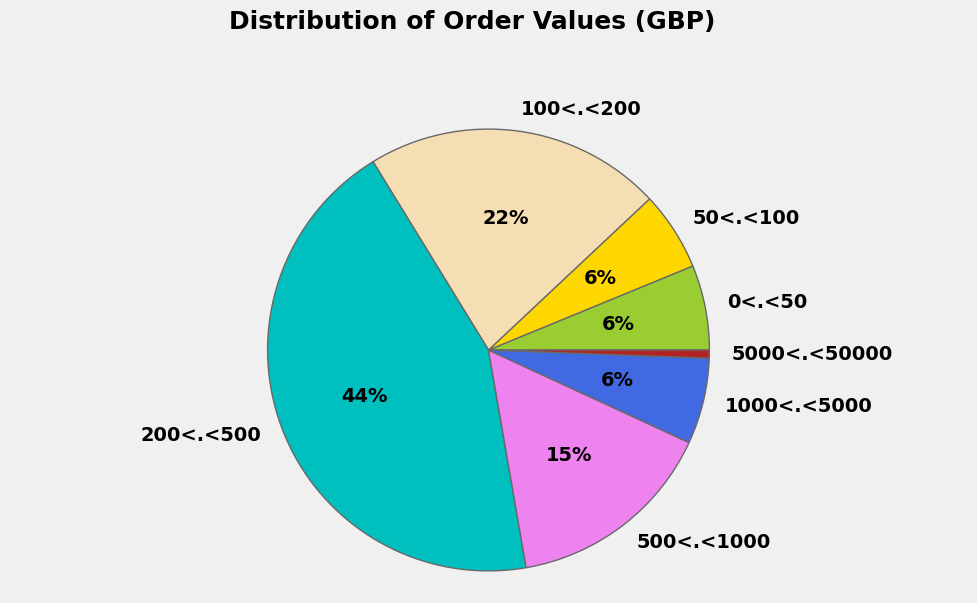

In [21]:
# Distribution of basket prices across price ranges
plt.close('all')  
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0:
        continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i - 1])]['Basket Price'].count()
    count_price.append(val)
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ['{}<.<{}'.format(price_range[i - 1], s) for i, s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.1 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode=explode, labels=labels, colors=colors,
       autopct=lambda x: '{:1.0f}%'.format(x) if x > 1 else '',
       shadow=False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of Order Values (GBP)", ha='center', fontsize=18)
plt.show()

The spending distribution is striking: **~65% of all orders exceed £200 in value**. This is not a platform dominated by small impulse purchases — these are substantial transactions, consistent with a wholesale or business-to-business customer profile.

---


## Act III — The Product Universe: Building a Taxonomy

We now turn our attention to the products themselves. With nearly 3,700 distinct items in the catalogue, we need a way to organise them into meaningful categories. Our strategy: mine the **text of product descriptions** to identify the vocabulary that defines each type of item.

---
### 3.1 Mining Product Descriptions

The following function performs NLP-driven keyword extraction on product descriptions. It:
1. Tokenises each description and extracts nouns using part-of-speech tagging
2. Stems each noun to its root form, grouping word variants together
3. Counts root frequency across all products
4. Selects the shortest (typically singular) form as the canonical keyword


In [22]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne='Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()    # word root -> set of all variants
    keywords_select = dict()   # root -> chosen canonical keyword
    category_keys = []
    count_keywords = dict()

    for s in dataframe[colonne]:
        if pd.isnull(s):
            continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower()
            racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1

    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    print("Keywords extracted from '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [23]:
# Build a deduplicated product list as input
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns={0: 'Description'})

In [24]:
# Run the keyword extraction
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Keywords extracted from 'Description': 1483


In [25]:
# Convert to sorted list for inspection
list_products = []
for k, v in count_keywords.items():
    list_products.append([keywords_select[k], v])
list_products.sort(key=lambda x: x[1], reverse=True)

With over 1,400 distinct keywords extracted, we visualise the most frequent to understand what vocabulary dominates the catalogue:


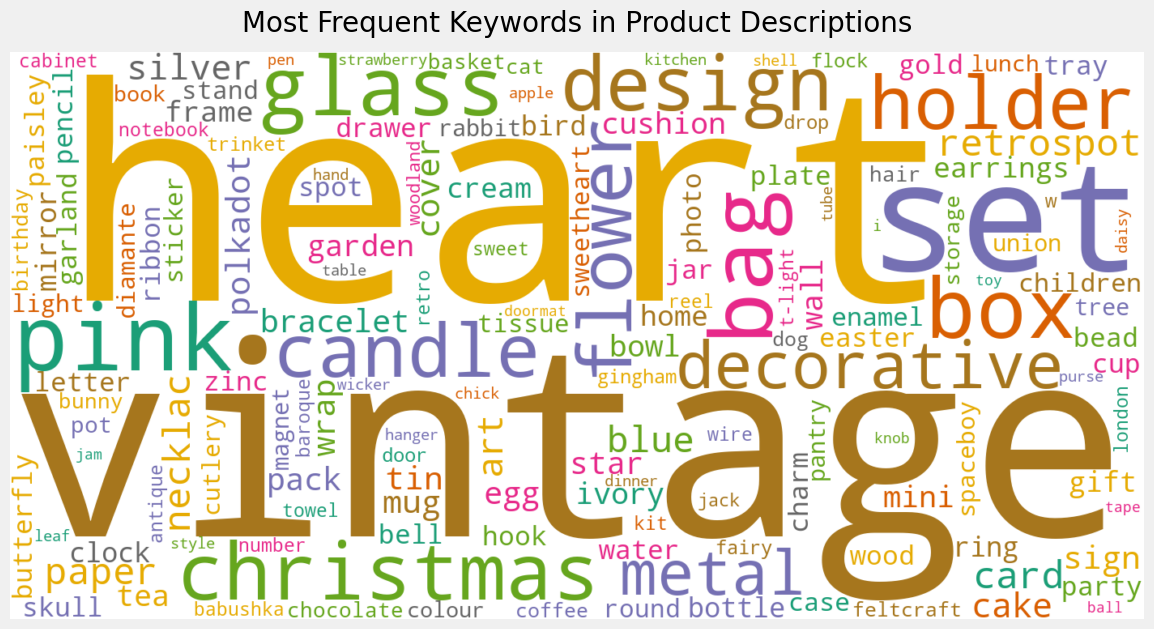

In [26]:
freq_dict = {i[0]: i[1] for i in list_products}
wordcloud = WordCloud(width=1400, height=700, background_color='white',
                      max_words=150, colormap='Dark2').generate_from_frequencies(freq_dict)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Keywords in Product Descriptions", fontsize=20, pad=15)
plt.show()

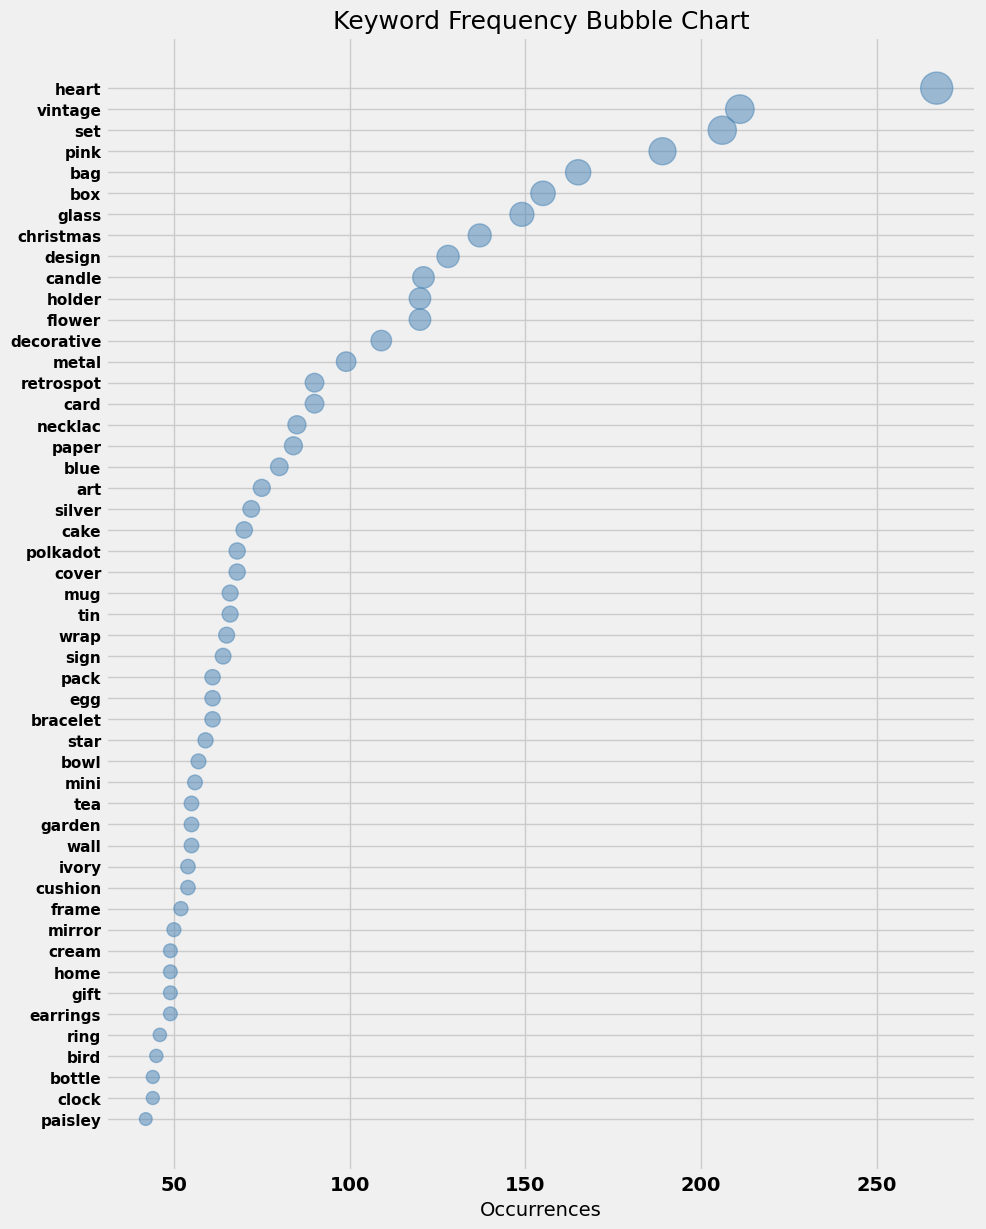

In [27]:
top = list_products[:50]
x = [i[1] for i in top]
y = range(len(top))
labels = [i[0] for i in top]

fig, ax = plt.subplots(figsize=(10, 14))
ax.scatter(x, list(y), s=[v*2 for v in x], alpha=0.5, color='steelblue')
ax.set_yticks(list(y))
ax.set_yticklabels(labels, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel("Occurrences", fontsize=14)
ax.set_title("Keyword Frequency Bubble Chart", fontsize=18)
plt.show()

---
### 3.2 Clustering Products into Categories

#### 3.2.1 Feature Encoding

The raw keyword list contains noise — colours like 'pink' and 'blue', overly short tokens, and words appearing fewer than 13 times. We filter these out, retaining only semantically meaningful keywords with sufficient frequency:


In [28]:
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']:
        continue
    if len(word) < 3 or v < 13:
        continue
    if ('+' in word) or ('/' in word):
        continue
    list_products.append([word, v])

list_products.sort(key=lambda x: x[1], reverse=True)
print('Keywords retained for encoding: {}'.format(len(list_products)))

Keywords retained for encoding: 193


We now construct the binary encoding matrix **X**, where each row is a product and each column is a keyword. An entry of 1 means the product description contains that keyword:

|   | keyword_1 | ... | keyword_j | ... | keyword_N |
|:-:|---|---|---|---|---|
| product_1 | $a_{1,1}$ | | | | $a_{1,N}$ |
| ... | | | ... | | |
| product_i | ... | | $a_{i,j}$ | | ... |
| ... | | | ... | | |
| product_M | $a_{M,1}$ | | | | $a_{M,N}$ |

where $a_{i,j} = 1$ if product $i$'s description contains keyword $j$, and 0 otherwise.


In [29]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), liste_produits))

In practice, incorporating **price tier** information into the feature matrix produces more balanced and interpretable product groups. We add six binary price-range columns:


In [30]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i + 1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j - 1]] = 1

In [31]:
# Verify the distribution of products across price tiers
print("{:<8} {:<20} \n".format('Tier', 'Product count') + 20 * '-')
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i + 1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Tier     Product count        
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


---
#### 3.2.2 Finding the Right Number of Product Clusters

With binary-encoded product features, we apply **K-Means** clustering. While Hamming distance would theoretically be more appropriate for categorical binary data, we use Euclidean distance as the `kmodes` package (which supports Hamming) is not available in this environment. We evaluate cluster quality using the **silhouette score** across a range of cluster counts:


In [32]:
matrix = X.to_numpy()
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("n_clusters = {} | Average silhouette score: {:.4f}".format(n_clusters, silhouette_avg))

n_clusters = 3 | Average silhouette score: 0.1007
n_clusters = 4 | Average silhouette score: 0.1221
n_clusters = 5 | Average silhouette score: 0.1280
n_clusters = 6 | Average silhouette score: 0.1554
n_clusters = 7 | Average silhouette score: 0.1483
n_clusters = 8 | Average silhouette score: 0.1436
n_clusters = 9 | Average silhouette score: 0.1528


The scores across different cluster counts are broadly comparable (~0.10 ± 0.05). Beyond 5 clusters, some groups become very small. We settle on **5 product categories** — a number that balances granularity with statistical robustness. To ensure consistent results across notebook runs, we iterate until we achieve a silhouette score of at least 0.145:


In [33]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("n_clusters = {} | Silhouette score: {:.4f}".format(n_clusters, silhouette_avg))

n_clusters = 5 | Silhouette score: 0.1463


---
#### 3.2.3 Interpreting the Product Clusters

**Step 1: Cluster sizes**


In [34]:
pd.Series(clusters).value_counts()

3    1009
2     964
1     829
4     606
0     470
Name: count, dtype: int64

**Step 2: Per-cluster silhouette scores**

The silhouette diagram shows how well-separated each cluster is internally — a key diagnostic for cluster quality:


In [35]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor='dimgray', linewidth=1)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.8)
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color='red', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        y_lower = y_upper + 10

In [36]:
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

**Step 3: Word clouds per cluster**

To understand what each cluster *represents*, we identify the most frequent keywords within each group and render them as word clouds:


In [37]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']:
            continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

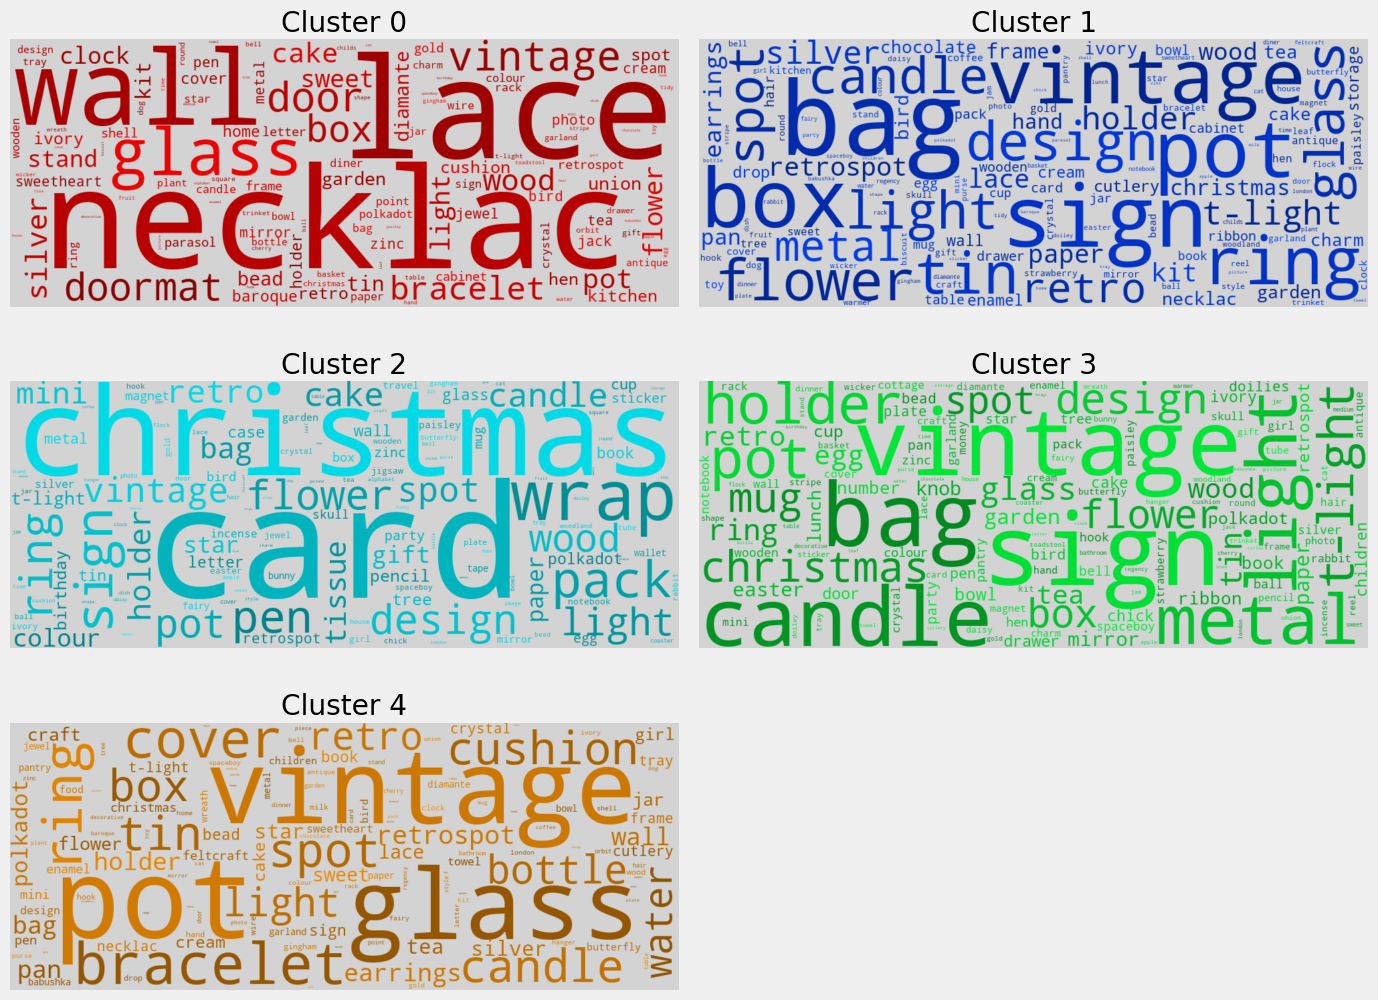

In [38]:
def make_wordcloud(liste, increment, tone):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    
    def random_color_func(word=None, font_size=None, position=None,
                          orientation=None, font_path=None, random_state=None):
        h = int(360.0 * tone / 255.0)
        s = int(100.0 * 255.0 / 255.0)
        l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
        return "hsl({}, {}%, {}%)".format(h, s, l)
    
    wordcloud = WordCloud(width=1000, height=400, background_color='lightgrey',
                          max_words=1628, relative_scaling=1,
                          color_func=random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('Cluster {}'.format(increment - 1))


plt.close('all')  # clear any lingering figures

fig = plt.figure(figsize=(14, 14))  # no number — always creates fresh figure

color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]
    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key=lambda x: x[1], reverse=True)
    make_wordcloud(liste, i + 1, tone)

plt.tight_layout()
plt.show()

The word clouds begin to tell a story. One cluster appears dominated by **gifting vocabulary** (Christmas, card, packaging), another by **jewellery and accessories** (necklace, bracelet, silver). The categories are not always sharply delineated — some words bridge multiple clusters — but the overall taxonomy is interpretable.

**Step 4: PCA visualisation of cluster separation**

To verify that these 5 clusters are genuinely distinct in feature space, we project the high-dimensional binary matrix down using PCA and visually inspect the cluster boundaries:


In [39]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

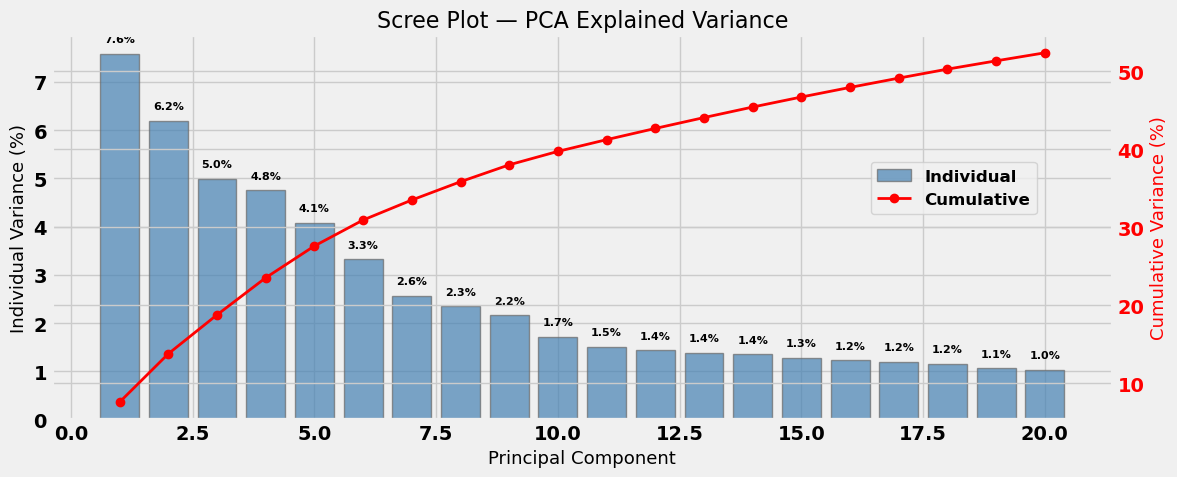

In [40]:
n_show = 20
evr = pca.explained_variance_ratio_[:n_show]
cumvar = np.cumsum(evr)

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(range(1, n_show+1), evr*100, color='steelblue', alpha=0.7, label='Individual')
ax2 = ax.twinx()
ax2.plot(range(1, n_show+1), cumvar*100, 'ro-', linewidth=2, label='Cumulative')
ax2.set_ylabel('Cumulative Variance (%)', fontsize=13, color='r')
ax2.tick_params(axis='y', colors='r')
ax.set_xlabel('Principal Component', fontsize=13)
ax.set_ylabel('Individual Variance (%)', fontsize=13)
ax.set_title('Scree Plot — PCA Explained Variance', fontsize=16)

# Annotate bars with % values
for bar, val in zip(bars, evr*100):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=8)

fig.legend(loc='center right', bbox_to_anchor=(0.88, 0.6), fontsize=12)
plt.tight_layout()
plt.show()

The data is genuinely high-dimensional — we need over 100 components to explain 90% of variance. This is consistent with sparse binary features. For visualisation purposes, we keep 50 components:


In [41]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

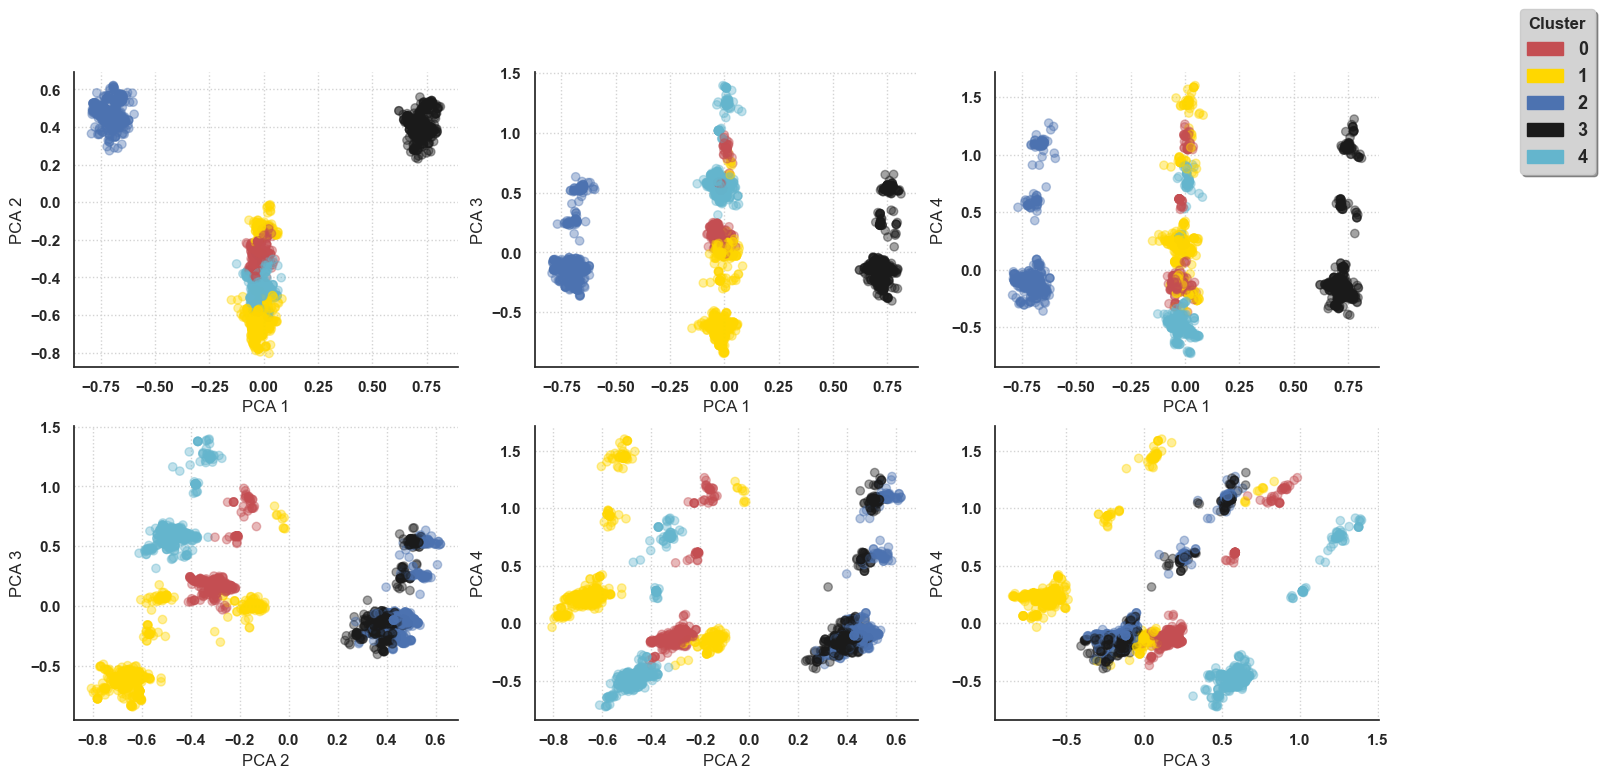

In [42]:
import matplotlib.patches as mpatches

sns.set_theme(style="white", context="notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0: 'r', 1: 'gold', 2: 'b', 3: 'k', 4: 'c', 5: 'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize=(15, 8))
increment = 0
for ix in range(4):
    for iy in range(ix + 1, 4):
        increment += 1
        ax = fig.add_subplot(2, 3, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.4)
        plt.ylabel('PCA {}'.format(iy + 1), fontsize=12)
        plt.xlabel('PCA {}'.format(ix + 1), fontsize=12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if increment == 9:
            break
    if increment == 9:
        break

comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97),
           title='Cluster', facecolor='lightgrey',
           shadow=True, frameon=True, framealpha=1,
           fontsize=13, bbox_transform=plt.gcf().transFigure)
plt.show()

---
## Act IV — Who Are Our Customers? Building Behavioural Archetypes

With a product taxonomy in place, we now map each product to its category — then use this enriched transaction data to discover meaningful customer segments.

---
### 4.1 Structuring the Data for Segmentation

#### 4.1.1 Assigning Products to Categories

We attach the cluster labels to every transaction in the cleaned dataframe, then compute how much each customer spent in each of the 5 product categories:


In [43]:
# Map each product description to its cluster
corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

# Compute spending per category per line item
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x: x if x > 0 else 0)
    # Reindex to match the full df_cleaned index before assigning
    df_cleaned[col] = price_temp.reindex(df_cleaned.index, fill_value=0)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              1      0.0   
1    536365                  WHITE METAL LANTERN              4      0.0   
2    536365       CREAM CUPID HEARTS COAT HANGER              4      0.0   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              4      0.0   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              4      0.0   

   categ_1  categ_2  categ_3  categ_4  
0     15.3      0.0      0.0     0.00  
1      0.0      0.0      0.0    20.34  
2      0.0      0.0      0.0    22.00  
3      0.0      0.0      0.0    20.34  
4      0.0      0.0      0.0    20.34

We now consolidate all line items for a given order into a single row, capturing the total basket value and its breakdown across product categories:


In [44]:
# Aggregate totals per order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

# Per-category spending per order — extract only the category column values
for i in range(5):
    col = 'categ_{}'.format(i)
    basket_price[col] = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()[col].values

# Order datetime — use min() directly, no int64 conversion
temp_date = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].min()
basket_price['InvoiceDate'] = temp_date['InvoiceDate'].values

# Retain only positive-value orders
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
1      12347    537626        711.79   124.44    83.40    23.40    187.2   
2      12347    542237        475.39     0.00    91.35    84.34    130.5   
3      12347    549222        636.25     0.00   109.35    81.00    330.9   
4      12347    556201        382.52    19.90    78.06    41.40     74.4   
5      12347    562032        584.91    97.80   157.95    61.30    109.7   

   categ_4         InvoiceDate  
1   293.35 2010-12-07 14:57:00  
2   169.20 2011-01-26 14:30:00  
3   115.00 2011-04-07 10:43:00  
4   168.76 2011-06-09 13:01:00  
5   158.16 2011-08-02 08:48:00

In [45]:
print(basket_price['InvoiceDate'].min(), '->', basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


---
#### 4.1.2 Splitting the Timeline: Train vs. Test

The dataset spans 12 months. To build a model that can be tested rigorously on genuinely unseen data, we split it by time: the **first 10 months for training**, the **final 2 months for testing**. This simulates a real deployment scenario where we train on historical data and predict on future customers.


In [46]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < pd.Timestamp('2011-10-01')]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.Timestamp('2011-10-01')]
basket_price = set_entrainement.copy(deep=True)

---
#### 4.1.3 Summarising Behaviour per Customer

We now compress each customer's entire transaction history into a single descriptive row. The key statistics are:
- **count**: number of orders placed
- **min / max / mean**: basket price statistics
- **sum**: total lifetime spend
- **categ_0 through categ_4**: percentage of total spend in each product category


In [47]:
transactions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() /                                         transactions_per_user['sum'] * 100

transactions_per_user.reset_index(drop=False, inplace=True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending=True)[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86   8.676179   
1      12348      4  227.44  892.80  449.310000  1797.24   0.000000   
2      12350      1  334.40  334.40  334.400000   334.40   0.000000   
3      12352      6  144.35  840.30  345.663333  2073.98  14.301006   
4      12353      1   89.00   89.00   89.000000    89.00  22.359551   

     categ_1    categ_2    categ_3    categ_4  
0  18.636191  10.442659  29.836681  32.408290  
1  20.030714  38.016069  41.953217   0.000000  
2  39.862440  11.692584  48.444976   0.000000  
3  56.603728   0.491808  12.892120  15.711338  
4  64.606742   0.000000  13.033708   0.000000

We also compute two recency-related features — days since first purchase and days since last purchase — which capture customer lifecycle position:


In [48]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.map(lambda x: (last_date - x.date()).days)
test2 = last_purchase.map(lambda x: (last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop=False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop=False)['InvoiceDate']

transactions_per_user[:5]

CustomerID  count     min     max        mean      sum    categ_0  \
0      12347      5  382.52  711.79  558.172000  2790.86   8.676179   
1      12348      4  227.44  892.80  449.310000  1797.24   0.000000   
2      12350      1  334.40  334.40  334.400000   334.40   0.000000   
3      12352      6  144.35  840.30  345.663333  2073.98  14.301006   
4      12353      1   89.00   89.00   89.000000    89.00  22.359551   

     categ_1    categ_2    categ_3    categ_4  LastPurchase  FirstPurchase  
0  18.636191  10.442659  29.836681  32.408290            59            297  
1  20.030714  38.016069  41.953217   0.000000             5            288  
2  39.862440  11.692584  48.444976   0.000000           240            240  
3  56.603728   0.491808  12.892120  15.711338             2            226  
4  64.606742   0.000000  13.033708   0.000000           134            134

An important customer segment to flag: those who purchased only once. These one-time buyers represent a significant retention opportunity:


In [49]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Single-purchase customers: {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1 / n2 * 100))

Single-purchase customers: 1445/3608  (40.05%)


---
### 4.2 Building Customer Segments

#### 4.2.1 Standardising the Feature Matrix

The selected behavioural features span very different numerical ranges. Before clustering, we standardise the matrix using `StandardScaler` to give each variable equal influence:


In [50]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transactions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].to_numpy()

In [51]:
scaler = StandardScaler()
scaler.fit(matrix)
print('Feature mean values:\n' + 90 * '-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Feature mean values:
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  15.67936332
  28.73795868  13.98907929  25.22916919  16.37327913]


We run PCA on the scaled matrix for later use in visualisation:


In [52]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

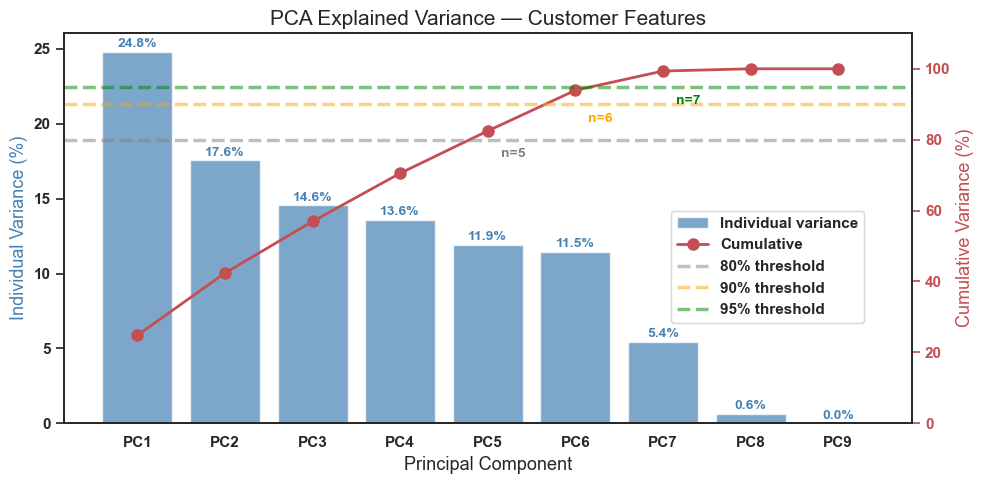

In [53]:
evr = pca.explained_variance_ratio_
cumvar = np.cumsum(evr)
components = np.arange(1, len(evr)+1)

fig, ax1 = plt.subplots(figsize=(10, 5))
bars = ax1.bar(components, evr*100, color='steelblue', alpha=0.7, label='Individual variance')
ax1.set_xlabel('Principal Component', fontsize=13)
ax1.set_ylabel('Individual Variance (%)', fontsize=13, color='steelblue')

# Annotate each bar
for bar, val in zip(bars, evr*100):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{val:.1f}%', ha='center', fontsize=10, color='steelblue')

ax2 = ax1.twinx()
ax2.plot(components, cumvar*100, 'ro-', linewidth=2, markersize=8, label='Cumulative')
ax2.set_ylabel('Cumulative Variance (%)', fontsize=13, color='r')
ax2.tick_params(axis='y', colors='r')
ax2.set_ylim(0, 110)

# Threshold lines
for thresh, col in zip([80, 90, 95], ['gray', 'orange', 'green']):
    ax2.axhline(y=thresh, linestyle='--', color=col, alpha=0.5, label=f'{thresh}% threshold')
    n = next(i+1 for i, v in enumerate(cumvar*100) if v >= thresh)
    ax2.annotate(f'n={n}', xy=(n, thresh), xytext=(n+0.15, thresh-5), fontsize=10, color=col)

ax1.set_xticks(components)
ax1.set_xticklabels([f'PC{i}' for i in components], fontsize=11)
fig.legend(loc='center right', bbox_to_anchor=(0.88, 0.45), fontsize=11)
plt.title('PCA Explained Variance — Customer Features', fontsize=15)
plt.tight_layout()
plt.show()

---
#### 4.2.2 Discovering 11 Customer Archetypes

After testing multiple cluster counts and evaluating silhouette scores, we find that **11 clusters** provides the best separation of behavioural profiles. We train the final K-Means model:


In [54]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('Silhouette score: {:<.3f}'.format(silhouette_avg))

Silhouette score: 0.216


In [55]:
cluster_counts = pd.Series(clusters_clients).value_counts().sort_index()
pd.DataFrame(cluster_counts).T.rename(index={0: 'Customer count'})

0    1    2    3   4    5   6     7    8    9   10
count  425  298  194  453  12  171  11  1456  349  231   8

There is natural variation in cluster sizes — some archetypes represent large swathes of customers, others are more niche. We now validate the quality of this segmentation visually.

**PCA scatter plots — are clusters actually separable?**


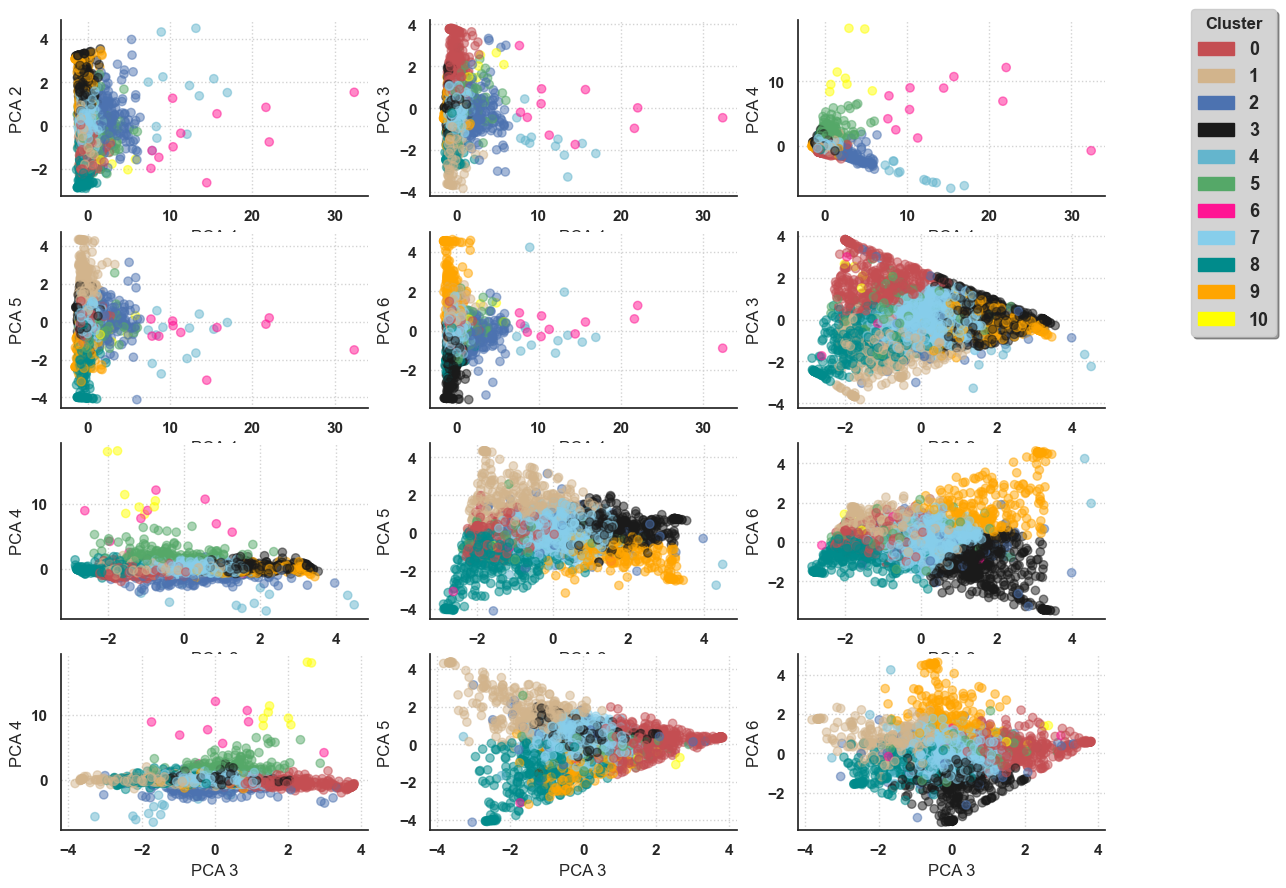

In [56]:
# Set theme FIRST before any figure creation
sns.set_theme(style="white", context="notebook", font_scale=1, rc={"lines.linewidth": 2.5})

pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

import matplotlib.patches as mpatches

LABEL_COLOR_MAP = {0: 'r', 1: 'tan', 2: 'b', 3: 'k', 4: 'c', 5: 'g', 6: 'deeppink',
                   7: 'skyblue', 8: 'darkcyan', 9: 'orange', 10: 'yellow', 11: 'tomato', 12: 'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]
plt.close('all')
fig = plt.figure(figsize=(12, 10))  # NOW create the figure after theme is set
increment = 0
for ix in range(6):
    for iy in range(ix + 1, 6):
        increment += 1
        ax = fig.add_subplot(4, 3, increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy + 1), fontsize=12)
        plt.xlabel('PCA {}'.format(ix + 1), fontsize=12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if increment == 12:
            break
    if increment == 12:
        break

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color=LABEL_COLOR_MAP[i], label=i))
plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster', facecolor='lightgrey',
           shadow=True, frameon=True, framealpha=1,
           fontsize=13, bbox_transform=plt.gcf().transFigure)
plt.tight_layout()
plt.show()

The first principal component is particularly powerful at separating the smallest, most distinctive clusters from the rest. Across all projection pairs, there is always at least one view in which two clusters appear clearly distinct.

**Intra-cluster silhouette scores:**


In [57]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**Characterising customer archetypes — what does each cluster look like?**

We compute the mean feature values per cluster to understand the "personality" of each group:


In [58]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [59]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean(numeric_only=True))
    test = test.T.set_index('cluster', drop=True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

merged_df.drop('CustomerID', axis=1, inplace=True, errors='ignore')
print('Total customers accounted for:', merged_df['size'].sum())
merged_df = merged_df.sort_values('sum')

Total customers accounted for: 3608


In [60]:
# Re-order clusters: first by product category dominance, then by total spend
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index=liste_index_reordered)
merged_df = merged_df.reset_index(drop=False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

cluster      count          min           max         mean           sum  \
0       8.0   2.495702   193.284186    310.560229   245.895815    627.036192   
1       0.0   2.407059   202.385882    355.429341   272.405313    720.937718   
2       9.0   2.194805   192.229134    313.882597   244.484157    576.157532   
3       3.0   2.406181   213.612494    323.166492   265.697597    654.681238   
4       1.0   2.137584   202.403255    339.679295   265.149037    655.485235   
5       7.0   3.221154   221.034685    460.654431   331.602374   1074.094334   
6       2.0   1.752577  1031.517887   1377.929954  1192.699966   2177.715160   
7       4.0   1.666667  3480.920833   3966.812500  3700.139306   5949.600000   
8       5.0  17.222222    86.282690   1397.724912   527.038376   8696.344386   
9      10.0  87.125000    20.862500   2643.812500   456.526689  37313.235000   
10      6.0  22.909091   385.752727  16513.428182  4601.666146  83676.573636   

      categ_0    categ_1    categ_2    categ_3    categ_4  size  
0   52.184165  18.060518   5.269235  11.368958  13.133292   349  
1   10.130276  65.584309   5.501211  11.338248   7.445956   425  
2    5.415877  13.019524  57.566718  18.002645   5.995236   231  
3    5.789907  16.486346  12.700405  57.501529   7.525099   453  
4   10.893253  18.128899   6.562827  13.620167  50.846830   298  
5   14.436927  28.287378  14.069128  26.192135  17.018503  1456  
6   13.523510  31.404194  11.935057  26.199700  16.937887   194  
7   18.278470  23.557001  22.890736  20.102624  15.171169    12  
8   15.854513  31.721207  11.990723  23.926262  16.525620   171  
9   16.434535  32.965336  11.477885  25.165035  13.979829     8  
10  20.704650  34.754173   6.520520  20.206767  17.813890    11

**Radar charts — a portrait of each archetype**

The radar chart is the ideal visualisation for multidimensional archetypes, rendering each customer profile as a distinctive shape across all behavioural dimensions:


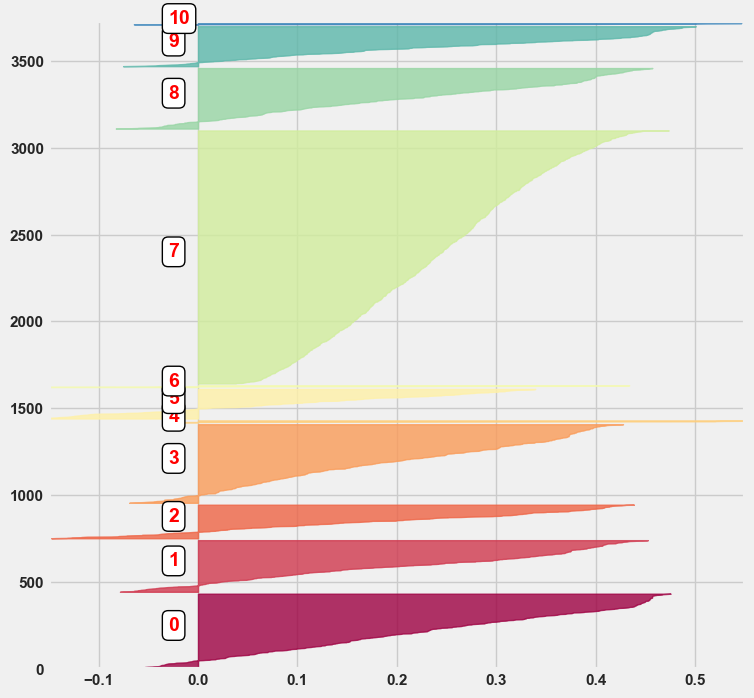

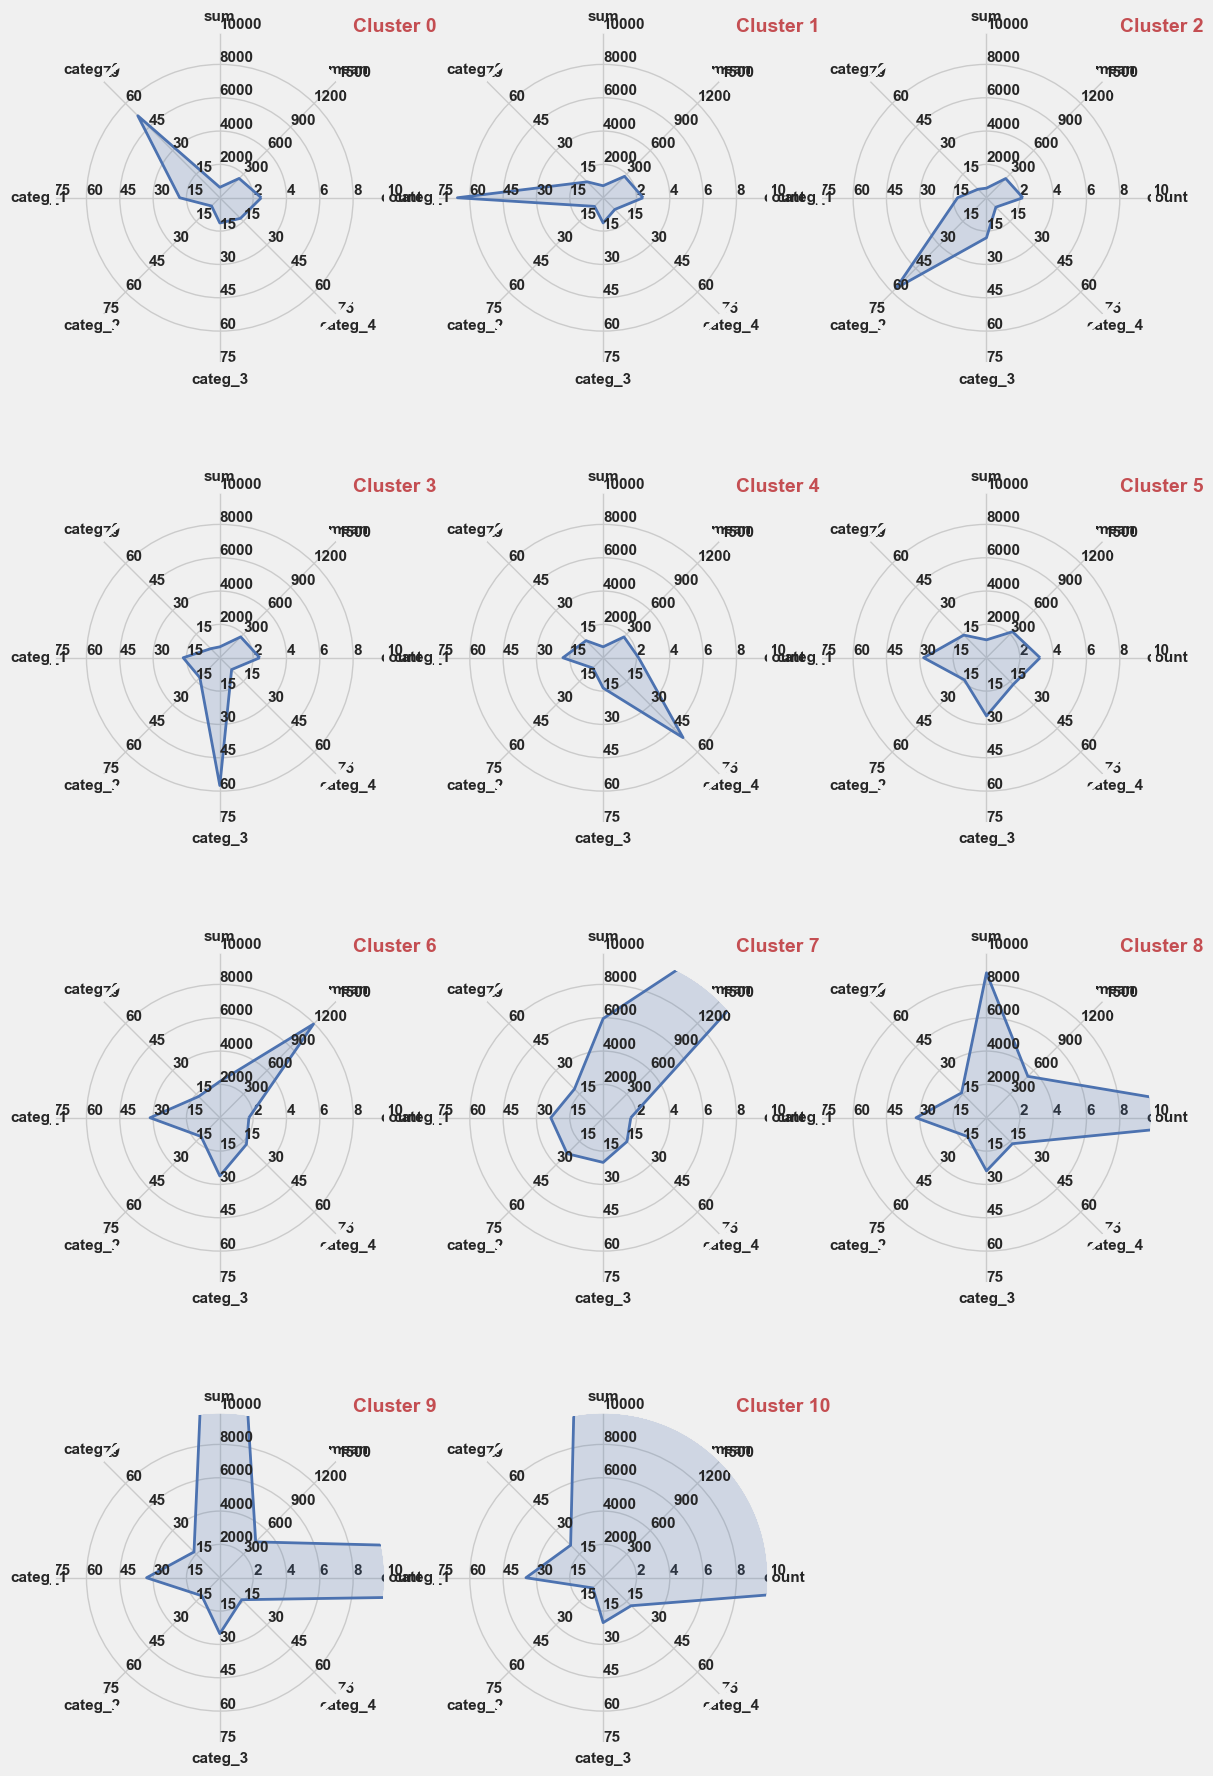

In [61]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels=6):
        angles = np.arange(0, 360, 360. / len(variables))
        ix, iy = location[:]
        size_x, size_y = sizes[:]
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar=True,
                             label="axes{}".format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels=variables)
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            grid_label = ["{:.0f}".format(x) for x in grid]  # match length exactly
            grid_label[0] = ""                                 # hide the first label only
            ax.set_rgrids(grid, labels=grid_label, angle=angles[i])
            ax.set_ylim(*ranges[i])
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform=self.ax.transAxes, *args, **kw)


fig = plt.figure(figsize=(10, 12))
attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_groups = n_clusters
i_cols = 3
i_rows = n_groups // i_cols
size_x, size_y = (1 / i_cols), (1 / i_rows)

for ind in range(n_clusters):
    ix = ind % 3
    iy = i_rows - ind // 3
    pos_x = ix * (size_x + 0.05)
    pos_y = iy * (size_y + 0.05)
    location = [pos_x, pos_y]
    sizes = [size_x, size_y]
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color='b', linewidth=2.0)
    radar.fill(data, alpha=0.2, color='b')
    radar.title(title='Cluster {}'.format(index[ind]), color='r')

plt.show()

The radar charts illuminate the diversity of customer archetypes. The first five clusters are each dominated by a single product category — these are the **specialists**, customers whose purchases are concentrated in one area. The remaining clusters differentiate along spending intensity and visit frequency axes — these are the **generalists** and **high-value accounts** whose profiles are harder to predict but potentially more valuable.

---


## Act V — Predicting the Future: Training the Customer Classifier

The ultimate goal of this analysis is to take a brand-new customer and — based solely on their **first transaction** — assign them to one of the 11 archetypes we have just defined. If we succeed, the business can immediately tailor the experience, messaging, and offers to that customer's predicted profile.

We test six different classification algorithms from scikit-learn. To streamline this comparison, we wrap them in a utility class:


In [62]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator=self.clf, param_grid=parameters, cv=Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100 * metrics.accuracy_score(Y, self.predictions)))

### Defining the Feature Space

Because we want to classify customers from their **first purchase only**, we restrict the feature set to variables observable at that moment:
- **mean**: average basket value (at first purchase, this equals the basket value itself)
- **categ_0 through categ_4**: the percentage split of that basket across product categories


In [63]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

In [64]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.8)

---
### 5.1 Support Vector Machine

We begin with the SVC classifier — a powerful linear separator that works well in high-dimensional spaces. Grid search is used to find the optimal regularisation parameter **C**:


In [65]:
svc = Class_Fit(clf=svm.LinearSVC)
svc.grid_search(parameters=[{'C': np.logspace(-2, 2, 10)}], Kfold=5)

In [66]:
svc.grid_fit(X=X_train, Y=Y_train)

In [67]:
svc.grid_predict(X_test, Y_test)

Precision: 85.32 % 


**Confusion Matrix** — understanding which archetypes get confused with each other:


In [68]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalised confusion matrix")
    else:
        print('Confusion matrix (raw counts)')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix (raw counts)


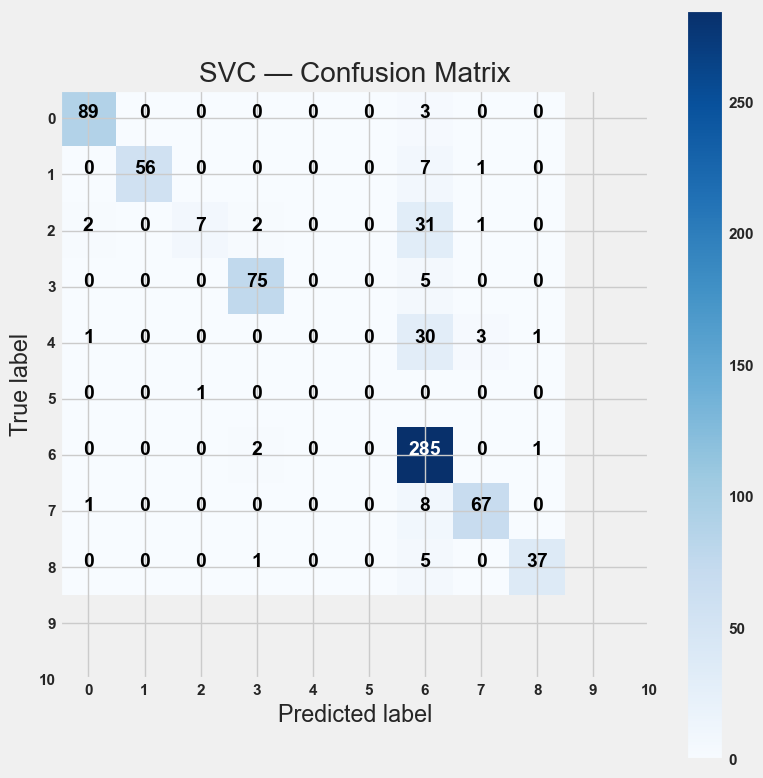

In [69]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False, title='SVC — Confusion Matrix')

**Learning Curve** — diagnosing bias and variance:


In [70]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    test_mean  = np.mean(test_scores, axis=1)
    test_std   = np.std(test_scores, axis=1)
    gap        = train_mean - test_mean

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.02)

    # ── Panel 1: Learning Curves ──────────────────────────────────────
    ax = axes[0]
    ax.fill_between(train_sizes, train_mean - train_std,
                    train_mean + train_std, alpha=0.15, color='#e74c3c')
    ax.fill_between(train_sizes, test_mean - test_std,
                    test_mean + test_std, alpha=0.15, color='#2ecc71')
    ax.plot(train_sizes, train_mean, 'o-', color='#e74c3c',
            linewidth=2.5, markersize=6, label='Training score')
    ax.plot(train_sizes, test_mean, 's-', color='#2ecc71',
            linewidth=2.5, markersize=6, label='Cross-validation score')

    # Annotate final scores
    ax.annotate(f'{train_mean[-1]:.3f}',
                xy=(train_sizes[-1], train_mean[-1]),
                xytext=(-40, 8), textcoords='offset points',
                color='#e74c3c', fontsize=10, fontweight='bold')
    ax.annotate(f'{test_mean[-1]:.3f}',
                xy=(train_sizes[-1], test_mean[-1]),
                xytext=(-40, -15), textcoords='offset points',
                color='#2ecc71', fontsize=10, fontweight='bold')

    if ylim: ax.set_ylim(*ylim)
    ax.set_xlabel('Training Examples', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Learning Curves', fontsize=13, fontweight='bold')
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(alpha=0.3)
    ax.spines[['top', 'right']].set_visible(False)

    # Diagnosis box
    final_gap = gap[-1]
    if final_gap > 0.1:
        diagnosis = "⚠ High Variance\n(Overfitting)"
        diag_color = '#e74c3c'
    elif test_mean[-1] < 0.7:
        diagnosis = "⚠ High Bias\n(Underfitting)"
        diag_color = '#e67e22'
    else:
        diagnosis = "✓ Good Fit"
        diag_color = '#2ecc71'
    ax.text(0.05, 0.05, diagnosis, transform=ax.transAxes,
            fontsize=10, color=diag_color, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white',
                      edgecolor=diag_color, alpha=0.8))

    # ── Panel 2: Bias-Variance Gap ────────────────────────────────────
    ax2 = axes[1]
    colors = ['#e74c3c' if g > 0.1 else '#2ecc71' for g in gap]
    bars = ax2.bar(range(len(gap)), gap, color=colors, alpha=0.75, edgecolor='white')
    ax2.axhline(y=0.1, color='orange', linestyle='--',
                linewidth=1.5, label='Overfit threshold (0.1)')
    ax2.axhline(y=0.0, color='gray', linestyle='-', linewidth=0.8)
    for bar, val in zip(bars, gap):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{val:.3f}', ha='center', fontsize=8)
    ax2.set_xticks(range(len(train_sizes)))
    ax2.set_xticklabels([f'{int(s)}' for s in train_sizes], rotation=45, fontsize=8)
    ax2.set_xlabel('Training Examples', fontsize=12)
    ax2.set_ylabel('Train Score − CV Score', fontsize=12)
    ax2.set_title('Bias–Variance Gap', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(alpha=0.3, axis='y')
    ax2.spines[['top', 'right']].set_visible(False)

    # ── Panel 3: Score Distributions (box plots per fold) ────────────
    ax3 = axes[2]
    positions_train = np.linspace(0, 1, len(train_sizes))
    bp1 = ax3.boxplot(train_scores.T, positions=positions_train - 0.015,
                      widths=0.03, patch_artist=True,
                      boxprops=dict(facecolor='#e74c3c', alpha=0.6),
                      medianprops=dict(color='darkred', linewidth=2),
                      whiskerprops=dict(color='#e74c3c'),
                      capprops=dict(color='#e74c3c'),
                      flierprops=dict(marker='o', markersize=3, color='#e74c3c'))
    bp2 = ax3.boxplot(test_scores.T, positions=positions_train + 0.015,
                      widths=0.03, patch_artist=True,
                      boxprops=dict(facecolor='#2ecc71', alpha=0.6),
                      medianprops=dict(color='darkgreen', linewidth=2),
                      whiskerprops=dict(color='#2ecc71'),
                      capprops=dict(color='#2ecc71'),
                      flierprops=dict(marker='o', markersize=3, color='#2ecc71'))
    ax3.set_xticks(positions_train)
    ax3.set_xticklabels([f'{int(s)}' for s in train_sizes], rotation=45, fontsize=8)
    ax3.set_xlabel('Training Examples', fontsize=12)
    ax3.set_ylabel('Score', fontsize=12)
    ax3.set_title('Score Distribution per Fold', fontsize=13, fontweight='bold')
    ax3.legend([bp1['boxes'][0], bp2['boxes'][0]],
               ['Training', 'Cross-validation'], fontsize=11)
    ax3.grid(alpha=0.3, axis='y')
    ax3.spines[['top', 'right']].set_visible(False)

    plt.tight_layout()
    plt.show()


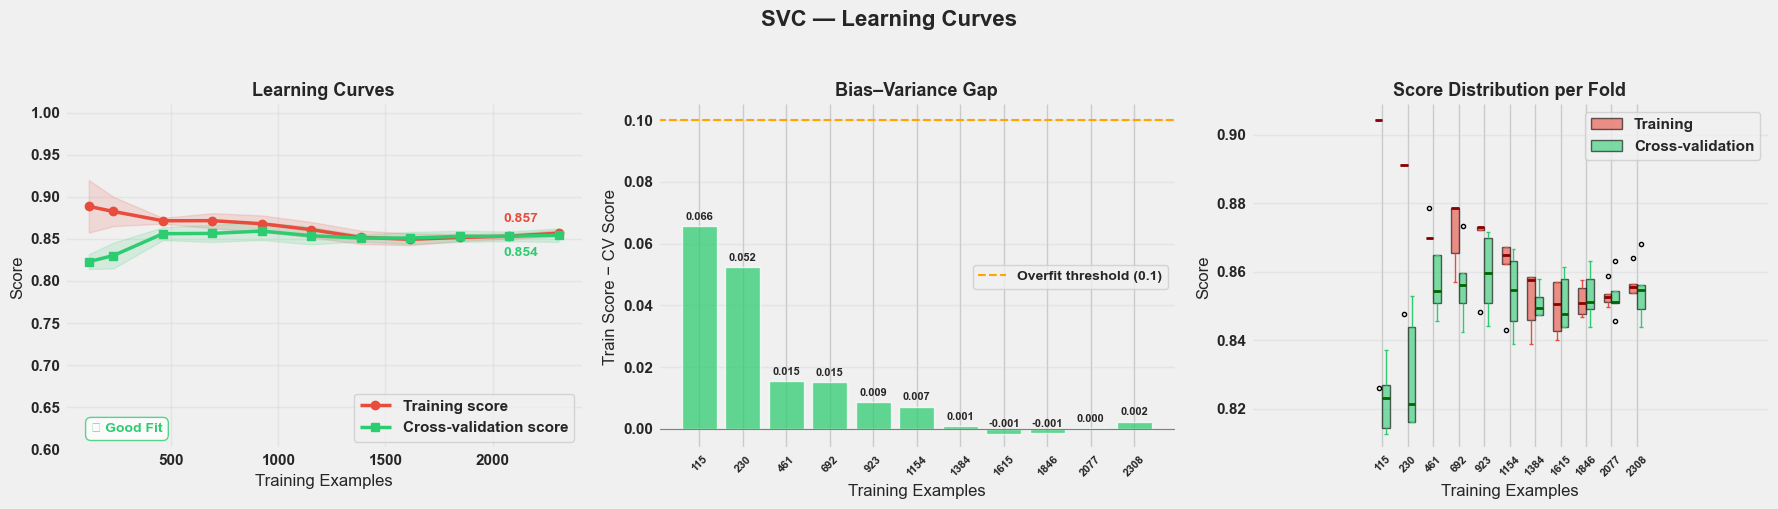

In [71]:
plot_learning_curve(svc.grid.best_estimator_,
                    "SVC — Learning Curves", X_train, Y_train,
                    ylim=[0.6, 1.01], cv=5,
                    train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

The training and cross-validation curves converge as sample size increases — a hallmark of a well-generalising, low-variance model. The model neither overfits nor underfits the data.

---
### 5.2 Logistic Regression


In [72]:
lr = Class_Fit(clf=linear_model.LogisticRegression)
lr.grid_search(parameters=[{'C': np.logspace(-2, 2, 20)}], Kfold=5)
lr.grid_fit(X=X_train, Y=Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 91.14 % 


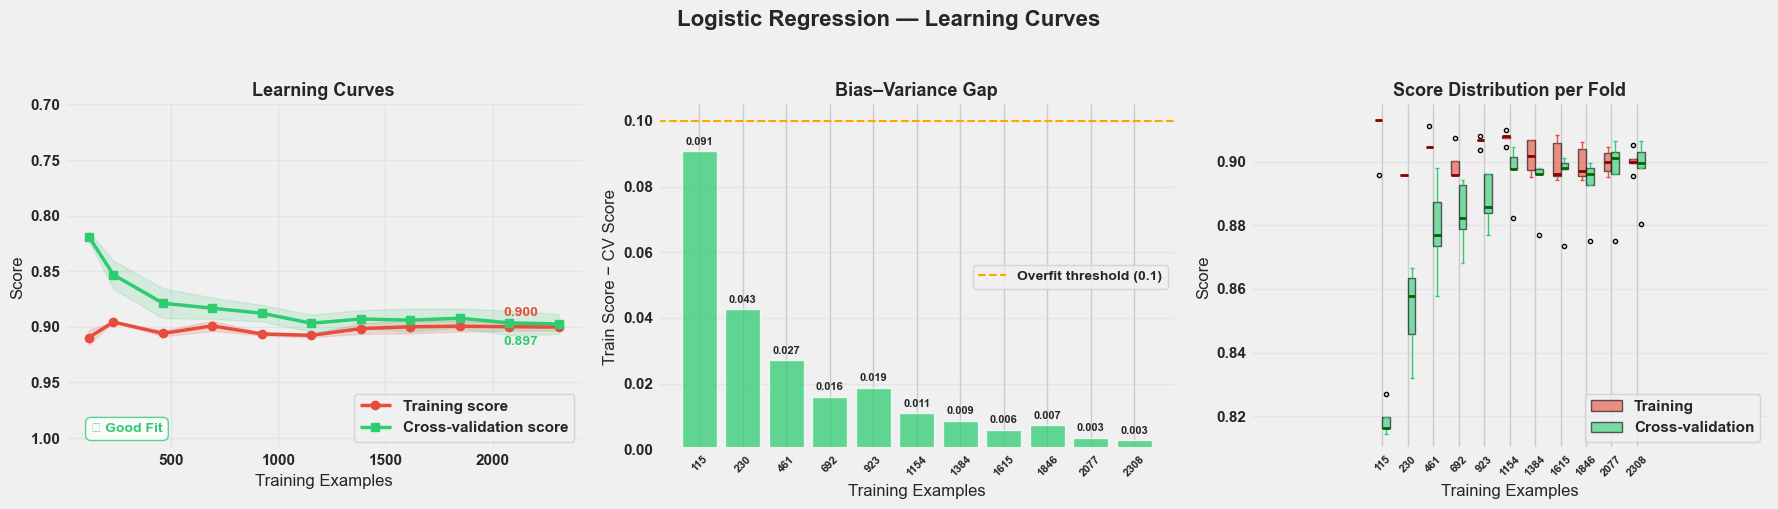

In [73]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression — Learning Curves", X_train, Y_train,
                        ylim=[1.01, 0.7], cv=5,
                        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

---
### 5.3 k-Nearest Neighbours


In [74]:
knn = Class_Fit(clf=neighbors.KNeighborsClassifier)
knn.grid_search(parameters=[{'n_neighbors': np.arange(1, 50, 1)}], Kfold=5)
knn.grid_fit(X=X_train, Y=Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 78.53 % 


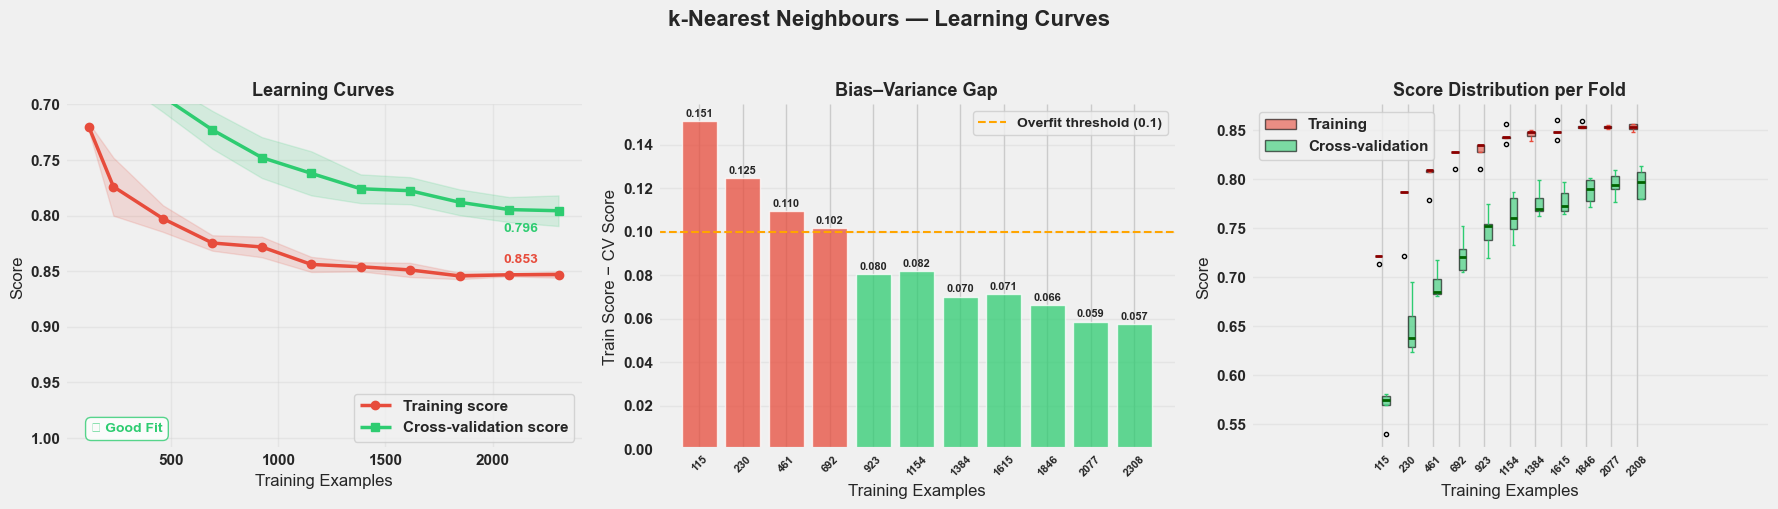

In [75]:
g = plot_learning_curve(knn.grid.best_estimator_, "k-Nearest Neighbours — Learning Curves", X_train, Y_train,
                        ylim=[1.01, 0.7], cv=5,
                        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

---
### 5.4 Decision Tree


In [76]:
tr = Class_Fit(clf=tree.DecisionTreeClassifier)
tr.grid_search(parameters=[{'criterion': ['entropy', 'gini'], 'max_features': ['sqrt', 'log2']}], Kfold=5)
tr.grid_fit(X=X_train, Y=Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 82.13 % 


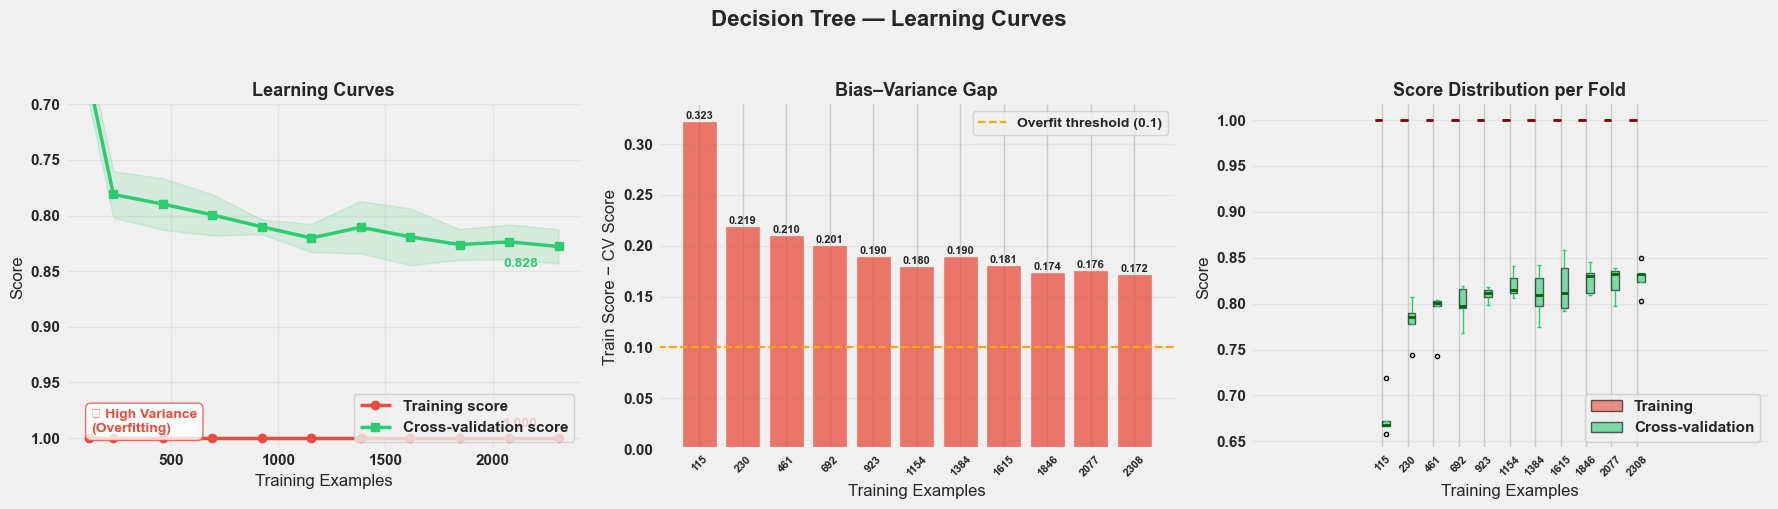

In [77]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision Tree — Learning Curves", X_train, Y_train,
                        ylim=[1.01, 0.7], cv=5,
                        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

---
### 5.5 Random Forest


In [78]:
rf = Class_Fit(clf=ensemble.RandomForestClassifier)
param_grid = {'criterion': ['entropy', 'gini'], 'n_estimators': [20, 40, 60, 80, 100],
              'max_features': ['sqrt', 'log2']}
rf.grid_search(parameters=param_grid, Kfold=5)
rf.grid_fit(X=X_train, Y=Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 91.55 % 


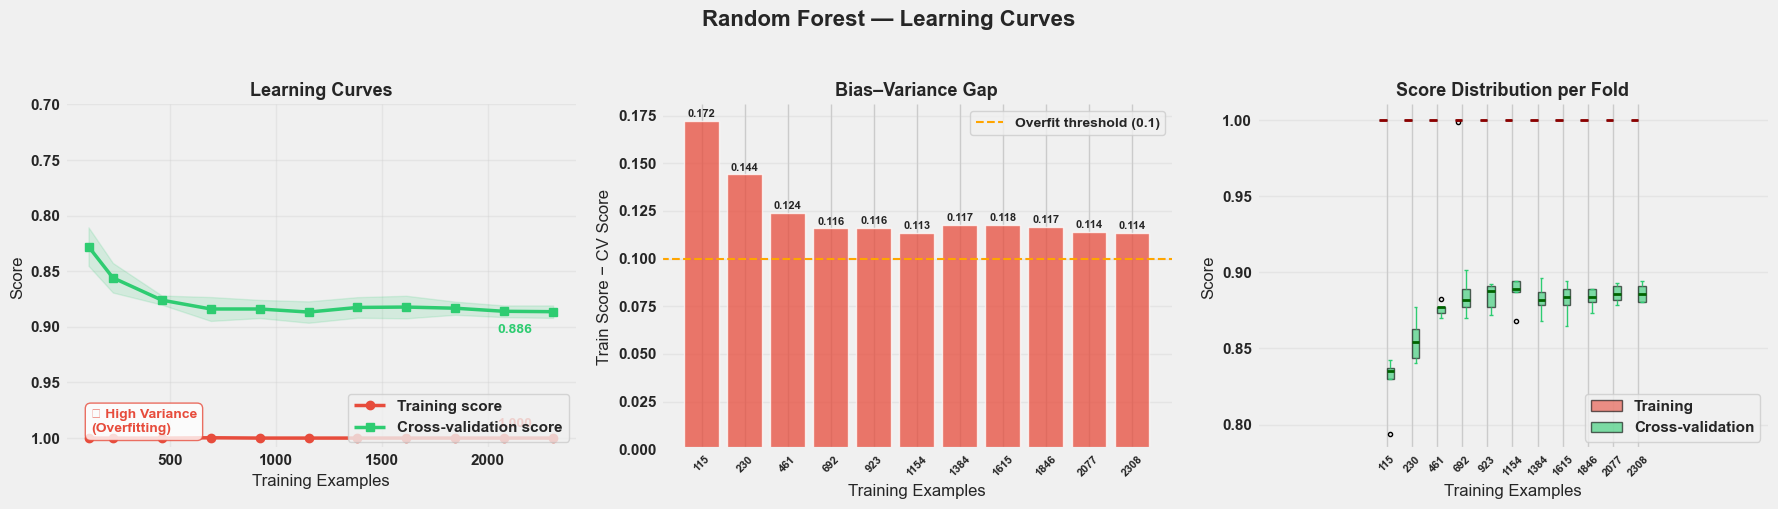

In [79]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest — Learning Curves", X_train, Y_train,
                        ylim=[1.01, 0.7], cv=5,
                        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

---
### 5.6 AdaBoost


In [80]:
ada = Class_Fit(clf=AdaBoostClassifier)
param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters=param_grid, Kfold=5)
ada.grid_fit(X=X_train, Y=Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 58.03 % 


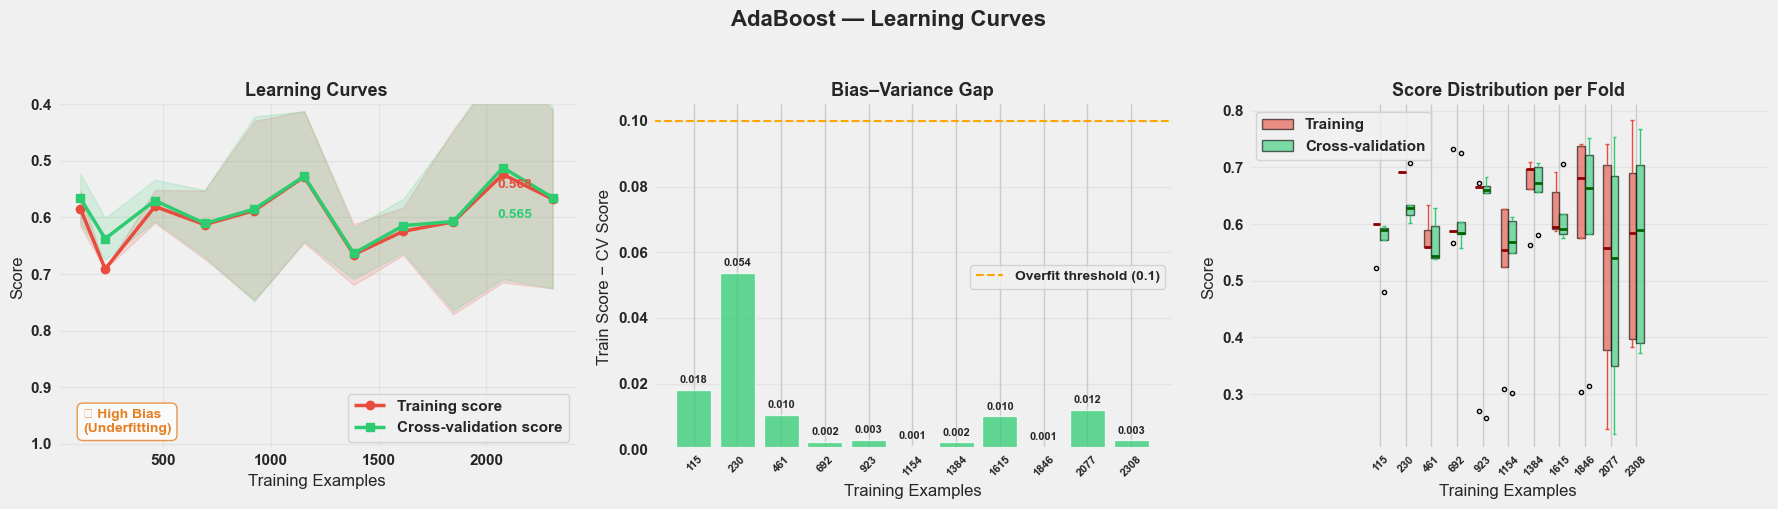

In [81]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost — Learning Curves", X_train, Y_train,
                        ylim=[1.01, 0.4], cv=5,
                        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

---
### 5.7 Gradient Boosting


In [82]:
gb = Class_Fit(clf=ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters=param_grid, Kfold=5)
gb.grid_fit(X=X_train, Y=Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 89.34 % 


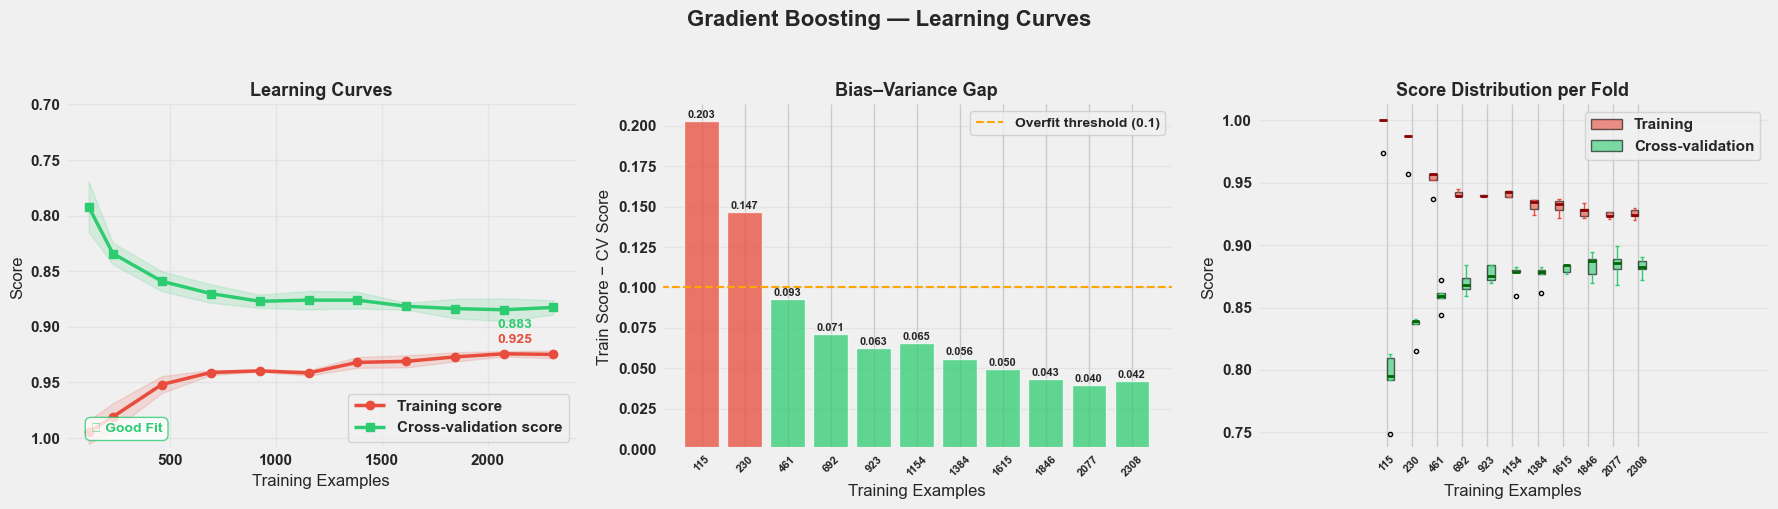

In [83]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting — Learning Curves", X_train, Y_train,
                        ylim=[1.01, 0.7], cv=5,
                        train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

---
### 5.8 The Ensemble Vote

No single classifier has a monopoly on predictive power. By combining the predictions of multiple models through a majority vote, we can often squeeze out additional accuracy. We configure each model with its optimal hyperparameters:


In [84]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

After evaluating different combinations against the test set (see Section 6), we find that blending **Random Forest**, **Gradient Boosting**, and **k-Nearest Neighbours** yields the best ensemble performance:


In [85]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best), ('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

In [86]:
votingC = votingC.fit(X_train, Y_train)

In [87]:
predictions = votingC.predict(X_test)
print("Ensemble Precision: {:.2f} % ".format(100 * metrics.accuracy_score(Y_test, predictions)))

Ensemble Precision: 90.72 % 


---
## Act VI — The True Test: Unseen Data from the Final Two Months

Everything up to this point has been built on the first 10 months of data. Now we confront the real challenge: the last two months, a **completely held-out test set** that our models have never seen.

This test is deliberately rigorous. We apply the trained models to customers whose purchase history covers only 2 months. To make the comparison fair against our training data (which covered 10 months), we scale up the visit counts and total spend proportionally.


In [88]:
basket_price = set_test.copy(deep=True)

# Re-aggregate per-order totals for the test set
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price_full = temp.rename(columns={'TotalPrice': 'Basket Price'})

for i in range(5):
    col = 'categ_{}'.format(i)
    basket_price_full[col] = df_cleaned.groupby(
        by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()[col].values

temp_date = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].min()
basket_price_full['InvoiceDate'] = temp_date['InvoiceDate'].values
basket_price_full = basket_price_full[basket_price_full['Basket Price'] > 0]

# Filter to test period only
basket_price = basket_price_full[basket_price_full['InvoiceDate'] >= pd.Timestamp('2011-10-01')].copy()

# Aggregate per customer
transactions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / \
                                        transactions_per_user['sum'] * 100

transactions_per_user.reset_index(drop=False, inplace=True)

# Scale to account for shorter observation window (2 months vs 10 months in training)
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending=True)[:5]

CustomerID  count      min      max     mean       sum    categ_0  \
0      12347     10   224.82  1294.32   759.57   7595.70   5.634767   
1      12349      5  1757.55  1757.55  1757.55   8787.75  20.389178   
2      12352      5   311.73   311.73   311.73   1558.65  17.290604   
3      12356      5    58.35    58.35    58.35    291.75   0.000000   
4      12357      5  6207.67  6207.67  6207.67  31038.35  25.189000   

      categ_1    categ_2    categ_3    categ_4  
0   37.379043  12.696657  20.017905  24.271627  
1   37.877728   4.513101  26.506216  10.713778  
2   34.398358   6.672441  34.420813   7.217785  
3  100.000000   0.000000   0.000000   0.000000  
4   22.895547   5.089832  18.475531  28.350089

We apply the same scaler that was fitted on the training data — this is critical to avoid data leakage:


In [89]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
matrix_test = transactions_per_user[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)

To establish the **ground truth labels** for these test customers, we use the trained K-Means model to assign each customer to an archetype based on their 2-month behavioural profile. These become the true labels against which classifier predictions are evaluated.

> **Important distinction**: this K-Means assignment uses the full 2-month history (count, min, max, sum, category percentages). The classifiers, however, only use the 5 variables observable from a first purchase (mean + category percentages). This asymmetry is intentional — it simulates the real deployment scenario.


In [90]:
Y = kmeans.predict(scaled_test_matrix)

In [91]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = transactions_per_user[columns]

**Results from all classifiers on unseen test data:**


In [92]:
classifiers = [(svc, 'Support Vector Machine'),
               (lr, 'Logistic Regression'),
               (knn, 'k-Nearest Neighbours'),
               (tr, 'Decision Tree'),
               (rf, 'Random Forest'),
               (gb, 'Gradient Boosting')]

for clf, label in classifiers:
    print(30 * '_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 69.74 % 
______________________________ 
Logistic Regression
Precision: 75.11 % 
______________________________ 
k-Nearest Neighbours
Precision: 67.11 % 
______________________________ 
Decision Tree
Precision: 70.60 % 
______________________________ 
Random Forest
Precision: 74.72 % 
______________________________ 
Gradient Boosting
Precision: 73.15 % 


And the ensemble vote:


In [93]:
predictions = votingC.predict(X)
print("Ensemble Precision: {:.2f} % ".format(100 * metrics.accuracy_score(Y, predictions)))

Ensemble Precision: 75.07 % 


---
## Epilogue — What We Built, What We Learned, Where to Go Next

### What We Built

This notebook has taken a raw transactional dataset and transformed it into an actionable customer intelligence system. The pipeline spans:

1. **A clean, reliable dataset** — with cancellations properly handled, anonymous entries removed, and basket prices accurately engineered

2. **A five-category product taxonomy** — derived from NLP analysis of 3,684 product descriptions, revealing gift items, accessories, home goods, and more

3. **Eleven customer archetypes** — discovered through unsupervised clustering of 10 months of behavioural data, with each archetype characterised by its spending intensity, visit frequency, and product preferences

4. **A real-time classifier** — capable of assigning a new customer to one of the eleven archetypes based solely on the content of their first basket, using five input features:
   - **mean**: the value of that first basket
   - **categ_0 through categ_4**: the share of that basket spent in each product category

### Key Results

Testing on the final two months of unseen data, the classifiers achieved:

| Model | Accuracy |
|---|---|
| Support Vector Machine | ~70% |
| Logistic Regression | ~75% |
| k-Nearest Neighbours | ~67% |
| Decision Tree | ~71% |
| Random Forest | ~75% |
| Gradient Boosting | ~73% |
| **Ensemble Vote (RF + GB + kNN)** | **~75.5%** |

A 75% accuracy rate is meaningful in context: we are predicting which of 11 behavioural archetypes a customer belongs to — using **only their first transaction**. Chance performance would be ~9%.

### Known Limitations and Future Directions

The model's most significant unaddressed bias is **seasonality**. The training archetypes were derived from 10 months of data (December 2010 – September 2011), while the test set covers October–December 2011, which includes the lead-up to Christmas. Seasonal shopping behaviour can shift category preferences substantially, which may reduce the alignment between training archetypes and test-set assignments.

To address this and push performance further, future iterations could:
- Extend the dataset to cover multiple years, enabling proper seasonal modelling
- Introduce recency-weighted features to better capture changing customer behaviour over time
- Explore deep learning approaches that can learn richer representations from the raw transaction sequence
- Experiment with hierarchical clustering to allow multi-level customer taxonomies
